In [1]:
!export AUTOGRAPH_VERBOSITY=0
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
import tensorflow as tf 
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
# tf.compat.v1.logging.set_verbosity(100)

In [2]:
%load_ext autoreload
%autoreload 2
import cantera as ct
import os
import gym 
import numpy as np 
import pandas as pd
from stable_baselines.common.policies import MlpPolicy, CnnLstmPolicy,MlpLstmPolicy
from stable_baselines.common.vec_env import SubprocVecEnv
from stable_baselines.bench import Monitor
from stable_baselines.results_plotter import load_results, ts2xy
from stable_baselines.common import set_global_seeds
from stable_baselines import ACKTR, PPO2
from envs.sim_env import SimEnv, NO_idx, CO_idx, O2_idx, H2O_idx
from envs.SimUtils import solvePhi_airSplit, equil, runMainBurner, correctNOx
import seaborn as sns

In [3]:
model = PPO2.load('Trained Models/PPO2_MlpLstmPolicy_HigherTempWeight_11182019_1600000.zip')

In [8]:
from stable_baselines.common.vec_env import DummyVecEnv
sim_env = SimEnv()
env = DummyVecEnv([lambda: sim_env])
# env = SimEnv()
obs = env.reset()
env.action_space.high

array([17733.37587108,  1690.62375258,  9642.49689204])

In [9]:
model.set_env(env)

In [12]:
import pdb 
game_over = False
results_list = []
while not game_over: 
    action, _states = model.predict(obs)
#     action = env.action_space.high[np.newaxis,:]
#     action = env.action_space.high[np.newaxis,:]
    obs, rewards, game_over, info = env.step(action)
    env.render(mode='human')
    g = env.envs[0].sec_stage_gas
    results_list.append([
        env.envs[0].age/1e-3, 
        g.T, 
        correctNOx(g.X[NO_idx], g.X[H2O_idx], g.X[O2_idx]),
        correctNOx(g.X[CO_idx], g.X[H2O_idx], g.X[O2_idx]),
        env.envs[0].mfc_main.mdot(0),
        env.envs[0].mfc_fuel_sec.mdot(0),
        env.envs[0].mfc_air_sec.mdot(0), 
        env.envs[0].remaining_main_burner_mass,
        env.envs[0].sec_fuel_remaining,
        env.envs[0].sec_air_remaining,
        rewards, ])

step|age_(ms)|T|phi_norm|NO|CO|Rem_Main|Rem_SecFuel|Rem_SecAir|Mdot_Main|Mdot_SecFuel|Mdot_SecAir|Max_Main|Max_SecFuel|Max_SecAir|Reward|Reward_Reactants|Reward_T|Reward_NO|Reward_CO
1| 0.00| 712.09| -0.00| 0.09| 1.65| 88.67| 1.69| 9.64| 40.27| 0.00| 582.43| 17733.38| 1690.62| 9642.50| 598.72|0.00| 0.00|498.72|100.00
2| 0.00| 470.03| 0.93| 0.00| 0.04| 88.67| 1.69| 9.64| 44.05| 506.94| 0.00| 17733.38| 1690.62| 9642.50| 598.77|0.00| 0.00|498.76|100.00
3| 0.00| 438.85| 0.96| 0.00| 0.03| 88.67| 1.69| 9.64| 39.68| 340.49| 0.00| 17733.38| 1690.62| 9642.50| 598.77|0.00| 0.00|498.76|100.00
4| 0.00| 418.83| 0.97| 0.00| 0.03| 88.67| 1.69| 9.64| 36.40| 372.79| 0.00| 17733.38| 1690.62| 9642.50| 598.77|0.00| 0.00|498.76|100.00
5| 0.00| 430.41| 0.97| 0.00| 0.04| 88.67| 1.69| 9.64| 36.40| 50.82| 66.63| 17733.38| 1690.62| 9642.50| 598.77|0.00| 0.00|498.76|100.00
6| 0.01| 443.14| 0.96| 0.00| 0.04| 88.67| 1.69| 9.64| 41.05| 0.00| 10.38| 17733.38| 1690.62| 9642.50| 598.77|0.00| 0.00|498.76|100.00
7| 0.01

66| 0.07| 525.02| 0.88| 0.00| 0.06| 88.66| 1.68| 9.62| 23.51| 280.39| 0.00| 17733.38| 1690.62| 9642.50| 598.83|0.06| 0.00|498.76|100.00
67| 0.07| 519.90| 0.89| 0.00| 0.05| 88.66| 1.68| 9.62| 38.25| 545.50| 0.00| 17733.38| 1690.62| 9642.50| 598.83|0.06| 0.00|498.76|100.00
68| 0.07| 524.36| 0.88| 0.00| 0.05| 88.66| 1.68| 9.62| 33.90| 0.00| 1485.70| 17733.38| 1690.62| 9642.50| 598.83|0.07| 0.00|498.76|100.00
69| 0.07| 524.80| 0.88| 0.00| 0.05| 88.66| 1.68| 9.62| 20.46| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 598.83|0.07| 0.00|498.76|100.00
70| 0.07| 524.00| 0.88| 0.00| 0.05| 88.66| 1.68| 9.62| 36.49| 150.27| 0.00| 17733.38| 1690.62| 9642.50| 598.83|0.07| 0.00|498.76|100.00
71| 0.07| 523.31| 0.88| 0.00| 0.05| 88.66| 1.68| 9.62| 30.79| 128.87| 0.00| 17733.38| 1690.62| 9642.50| 598.83|0.07| 0.00|498.76|100.00
72| 0.07| 527.66| 0.87| 0.00| 0.05| 88.66| 1.68| 9.62| 26.44| 0.00| 1639.42| 17733.38| 1690.62| 9642.50| 598.83|0.07| 0.00|498.76|100.00
73| 0.07| 526.44| 0.88| 0.00| 0.05| 88.66| 1.68|

135| 0.13| 525.70| 0.87| 0.00| 0.05| 88.66| 1.67| 9.59| 49.59| 0.00| 77.07| 17733.38| 1690.62| 9642.50| 598.90|0.15| 0.00|498.76|100.00
136| 0.14| 526.70| 0.87| 0.00| 0.05| 88.66| 1.67| 9.59| 56.15| 0.00| 378.59| 17733.38| 1690.62| 9642.50| 598.91|0.15| 0.00|498.76|100.00
137| 0.14| 527.09| 0.87| 0.00| 0.05| 88.66| 1.67| 9.59| 52.20| 153.01| 565.40| 17733.38| 1690.62| 9642.50| 598.91|0.15| 0.00|498.76|100.00
138| 0.14| 527.32| 0.87| 0.00| 0.05| 88.66| 1.67| 9.59| 23.45| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 598.91|0.15| 0.00|498.76|100.00
139| 0.14| 525.81| 0.87| 0.00| 0.05| 88.66| 1.67| 9.59| 39.85| 383.18| 0.00| 17733.38| 1690.62| 9642.50| 598.91|0.15| 0.00|498.76|100.00
140| 0.14| 525.87| 0.87| 0.00| 0.05| 88.66| 1.67| 9.59| 15.51| 48.07| 135.23| 17733.38| 1690.62| 9642.50| 598.91|0.15| 0.00|498.76|100.00
141| 0.14| 527.11| 0.87| 0.00| 0.05| 88.66| 1.67| 9.59| 28.22| 0.00| 870.26| 17733.38| 1690.62| 9642.50| 598.91|0.15| 0.00|498.76|100.00
142| 0.14| 528.18| 0.87| 0.00| 0.05| 88.6

199| 0.20| 529.92| 0.87| 0.00| 0.05| 88.66| 1.66| 9.57| 23.40| 0.00| 1175.94| 17733.38| 1690.62| 9642.50| 598.97|0.21| 0.00|498.76|100.00
200| 0.20| 530.13| 0.87| 0.00| 0.05| 88.66| 1.66| 9.57| 29.51| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 598.97|0.21| 0.00|498.76|100.00
201| 0.20| 531.30| 0.86| 0.00| 0.05| 88.66| 1.66| 9.57| 33.94| 0.00| 1257.12| 17733.38| 1690.62| 9642.50| 598.97|0.22| 0.00|498.76|100.00
202| 0.20| 530.90| 0.86| 0.00| 0.05| 88.66| 1.66| 9.57| 33.46| 421.89| 1153.41| 17733.38| 1690.62| 9642.50| 598.97|0.22| 0.00|498.76|100.00
203| 0.20| 529.90| 0.87| 0.00| 0.05| 88.66| 1.66| 9.57| 60.49| 406.82| 0.00| 17733.38| 1690.62| 9642.50| 598.97|0.22| 0.00|498.76|100.00
204| 0.20| 530.92| 0.86| 0.00| 0.05| 88.66| 1.66| 9.57| 33.58| 0.00| 1101.33| 17733.38| 1690.62| 9642.50| 598.98|0.22| 0.00|498.76|100.00
205| 0.20| 529.96| 0.87| 0.00| 0.05| 88.66| 1.66| 9.57| 30.93| 549.52| 969.18| 17733.38| 1690.62| 9642.50| 598.98|0.23| 0.00|498.76|100.00
206| 0.21| 529.06| 0.87| 0.00| 0.05

264| 0.26| 536.75| 0.86| 0.00| 0.05| 88.66| 1.65| 9.54| 43.26| 167.67| 717.45| 17733.38| 1690.62| 9642.50| 599.03|0.29| 0.00|498.76|100.00
265| 0.26| 536.24| 0.86| 0.00| 0.05| 88.66| 1.65| 9.54| 23.23| 390.42| 811.85| 17733.38| 1690.62| 9642.50| 599.03|0.29| 0.00|498.76|100.00
266| 0.27| 536.47| 0.86| 0.00| 0.05| 88.66| 1.65| 9.54| 58.81| 36.84| 52.59| 17733.38| 1690.62| 9642.50| 599.03|0.29| 0.00|498.76|100.00
267| 0.27| 535.49| 0.86| 0.00| 0.05| 88.66| 1.65| 9.54| 46.73| 448.36| 0.00| 17733.38| 1690.62| 9642.50| 599.04|0.29| 0.00|498.76|100.00
268| 0.27| 535.61| 0.86| 0.00| 0.05| 88.66| 1.65| 9.54| 54.41| 108.60| 258.64| 17733.38| 1690.62| 9642.50| 599.04|0.29| 0.00|498.76|100.00
269| 0.27| 535.39| 0.86| 0.00| 0.05| 88.66| 1.65| 9.54| 23.77| 197.41| 354.65| 17733.38| 1690.62| 9642.50| 599.04|0.29| 0.00|498.76|100.00
270| 0.27| 535.53| 0.86| 0.00| 0.05| 88.66| 1.65| 9.54| 27.66| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 599.04|0.29| 0.00|498.76|100.00
271| 0.27| 535.83| 0.86| 0.00| 0.05

335| 0.34| 538.43| 0.85| 0.00| 0.04| 88.66| 1.64| 9.52| 19.66| 363.94| 0.00| 17733.38| 1690.62| 9642.50| 599.09|0.37| 0.00|498.76|100.00
336| 0.34| 538.84| 0.85| 0.00| 0.04| 88.66| 1.64| 9.52| 47.31| 0.00| 528.47| 17733.38| 1690.62| 9642.50| 599.09|0.37| 0.00|498.76|100.00
337| 0.34| 539.17| 0.85| 0.00| 0.04| 88.66| 1.64| 9.51| 39.86| 0.00| 416.30| 17733.38| 1690.62| 9642.50| 599.09|0.37| 0.00|498.76|100.00
338| 0.34| 539.74| 0.85| 0.00| 0.04| 88.66| 1.64| 9.51| 44.36| 0.00| 968.66| 17733.38| 1690.62| 9642.50| 599.10|0.37| 0.00|498.76|100.00
339| 0.34| 539.89| 0.85| 0.00| 0.04| 88.66| 1.64| 9.51| 36.38| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 599.10|0.37| 0.00|498.76|100.00
340| 0.34| 540.20| 0.85| 0.00| 0.04| 88.66| 1.64| 9.51| 7.98| 0.00| 675.17| 17733.38| 1690.62| 9642.50| 599.10|0.37| 0.00|498.76|100.00
341| 0.34| 540.76| 0.85| 0.00| 0.04| 88.66| 1.64| 9.51| 18.54| 0.00| 1222.38| 17733.38| 1690.62| 9642.50| 599.10|0.38| 0.00|498.76|100.00
342| 0.34| 540.88| 0.85| 0.00| 0.04| 88.65|

405| 0.41| 545.84| 0.85| 0.00| 0.05| 88.65| 1.64| 9.49| 30.75| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 599.13|0.44| 0.00|498.76|100.00
406| 0.41| 545.95| 0.84| 0.00| 0.05| 88.65| 1.64| 9.49| 27.42| 0.00| 41.07| 17733.38| 1690.62| 9642.50| 599.13|0.44| 0.00|498.76|100.00
407| 0.41| 546.18| 0.84| 0.00| 0.05| 88.65| 1.64| 9.49| 32.09| 0.00| 363.53| 17733.38| 1690.62| 9642.50| 599.13|0.44| 0.00|498.76|100.00
408| 0.41| 546.34| 0.84| 0.00| 0.05| 88.65| 1.64| 9.49| 35.16| 0.00| 123.05| 17733.38| 1690.62| 9642.50| 599.13|0.44| 0.00|498.76|100.00
409| 0.41| 546.32| 0.84| 0.00| 0.05| 88.65| 1.64| 9.49| 34.12| 72.56| 0.00| 17733.38| 1690.62| 9642.50| 599.13|0.44| 0.00|498.76|100.00
410| 0.41| 545.72| 0.85| 0.00| 0.05| 88.65| 1.64| 9.49| 60.93| 419.12| 0.00| 17733.38| 1690.62| 9642.50| 599.13|0.44| 0.00|498.76|100.00
411| 0.41| 546.00| 0.85| 0.00| 0.05| 88.65| 1.64| 9.49| 40.27| 0.00| 440.04| 17733.38| 1690.62| 9642.50| 599.13|0.44| 0.00|498.76|100.00
412| 0.41| 546.08| 0.85| 0.00| 0.05| 88.65| 1

477| 0.48| 549.00| 0.84| 0.00| 0.04| 88.65| 1.63| 9.46| 30.86| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 599.18|0.52| 0.00|498.76|100.00
478| 0.48| 549.20| 0.84| 0.00| 0.04| 88.65| 1.63| 9.46| 48.03| 0.00| 209.99| 17733.38| 1690.62| 9642.50| 599.17|0.52| 0.00|498.76|100.00
479| 0.48| 549.50| 0.84| 0.00| 0.04| 88.65| 1.63| 9.46| 19.04| 266.94| 2589.19| 17733.38| 1690.62| 9642.50| 599.18|0.53| 0.00|498.76|100.00
480| 0.48| 549.60| 0.84| 0.00| 0.04| 88.65| 1.63| 9.45| 19.75| 0.00| 138.79| 17733.38| 1690.62| 9642.50| 599.18|0.53| 0.00|498.76|100.00
481| 0.48| 549.47| 0.84| 0.00| 0.04| 88.65| 1.63| 9.45| 45.91| 161.24| 0.00| 17733.38| 1690.62| 9642.50| 599.18|0.53| 0.00|498.76|100.00
482| 0.48| 549.98| 0.84| 0.00| 0.04| 88.65| 1.63| 9.45| 41.16| 31.05| 1709.82| 17733.38| 1690.62| 9642.50| 599.18|0.53| 0.00|498.76|100.00
483| 0.48| 550.04| 0.84| 0.00| 0.04| 88.65| 1.63| 9.45| 52.45| 56.05| 0.00| 17733.38| 1690.62| 9642.50| 599.18|0.53| 0.00|498.76|100.00
484| 0.48| 549.98| 0.84| 0.00| 0.04| 88

553| 0.55| 551.62| 0.83| 0.00| 0.04| 88.65| 1.62| 9.42| 28.73| 139.65| 0.00| 17733.38| 1690.62| 9642.50| 599.20|0.61| 0.00|498.76|100.00
554| 0.55| 551.75| 0.83| 0.00| 0.04| 88.65| 1.62| 9.42| 25.39| 0.00| 289.02| 17733.38| 1690.62| 9642.50| 599.20|0.61| 0.00|498.76|100.00
555| 0.56| 551.88| 0.83| 0.00| 0.04| 88.65| 1.62| 9.42| 52.89| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 599.20|0.61| 0.00|498.76|100.00
556| 0.56| 550.95| 0.84| 0.00| 0.04| 88.65| 1.62| 9.42| 47.30| 883.05| 959.82| 17733.38| 1690.62| 9642.50| 599.20|0.61| 0.00|498.76|100.00
557| 0.56| 551.09| 0.84| 0.00| 0.04| 88.65| 1.62| 9.42| 24.09| 0.00| 383.15| 17733.38| 1690.62| 9642.50| 599.20|0.62| 0.00|498.76|100.00
558| 0.56| 551.10| 0.84| 0.00| 0.04| 88.65| 1.62| 9.42| 1.62| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 599.20|0.62| 0.00|498.76|100.00
559| 0.56| 551.05| 0.84| 0.00| 0.04| 88.65| 1.62| 9.42| 14.52| 57.69| 0.00| 17733.38| 1690.62| 9642.50| 599.20|0.62| 0.00|498.76|100.00
560| 0.56| 550.67| 0.84| 0.00| 0.04| 88.65| 1

628| 0.63| 553.56| 0.83| 0.00| 0.04| 88.64| 1.62| 9.40| 20.96| 288.21| 0.00| 17733.38| 1690.62| 9642.50| 599.20|0.68| 0.00|498.76|100.00
629| 0.63| 553.28| 0.83| 0.00| 0.04| 88.64| 1.62| 9.40| 40.58| 287.53| 0.00| 17733.38| 1690.62| 9642.50| 599.20|0.68| 0.00|498.76|100.00
630| 0.63| 553.25| 0.83| 0.00| 0.04| 88.64| 1.62| 9.40| 41.17| 91.97| 0.00| 17733.38| 1690.62| 9642.50| 599.20|0.68| 0.00|498.76|100.00
631| 0.63| 553.21| 0.83| 0.00| 0.04| 88.64| 1.62| 9.40| 21.47| 117.04| 342.78| 17733.38| 1690.62| 9642.50| 599.20|0.69| 0.00|498.76|100.00
632| 0.63| 553.37| 0.83| 0.00| 0.04| 88.64| 1.62| 9.40| 33.20| 0.00| 403.99| 17733.38| 1690.62| 9642.50| 599.20|0.69| 0.00|498.76|100.00
633| 0.63| 553.33| 0.83| 0.00| 0.04| 88.64| 1.62| 9.40| 37.23| 148.01| 381.15| 17733.38| 1690.62| 9642.50| 599.20|0.69| 0.00|498.76|100.00
634| 0.63| 553.72| 0.83| 0.00| 0.04| 88.64| 1.62| 9.39| 23.03| 0.00| 1711.83| 17733.38| 1690.62| 9642.50| 599.20|0.69| 0.00|498.76|100.00
635| 0.64| 553.77| 0.83| 0.00| 0.04| 

707| 0.71| 555.51| 0.83| 0.00| 0.04| 88.64| 1.61| 9.37| 53.39| 0.00| 278.72| 17733.38| 1690.62| 9642.50| 599.17|0.76| 0.00|498.76|100.00
708| 0.71| 555.18| 0.83| 0.00| 0.04| 88.64| 1.61| 9.37| 34.80| 431.17| 638.05| 17733.38| 1690.62| 9642.50| 599.17|0.77| 0.00|498.76|100.00
709| 0.71| 555.25| 0.83| 0.00| 0.04| 88.64| 1.61| 9.37| 8.53| 0.00| 288.26| 17733.38| 1690.62| 9642.50| 599.17|0.77| 0.00|498.76|100.00
710| 0.71| 555.30| 0.83| 0.00| 0.04| 88.64| 1.61| 9.37| 25.16| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 599.17|0.77| 0.00|498.76|100.00
711| 0.71| 555.35| 0.83| 0.00| 0.04| 88.64| 1.61| 9.37| 26.10| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 599.17|0.77| 0.00|498.76|100.00
712| 0.71| 555.71| 0.83| 0.00| 0.04| 88.64| 1.61| 9.36| 20.36| 0.00| 1870.23| 17733.38| 1690.62| 9642.50| 599.17|0.77| 0.00|498.76|100.00
713| 0.71| 555.96| 0.83| 0.00| 0.04| 88.64| 1.61| 9.36| 36.07| 0.00| 1026.06| 17733.38| 1690.62| 9642.50| 599.17|0.77| 0.00|498.76|100.00
714| 0.71| 556.08| 0.83| 0.00| 0.04| 88.64

786| 0.79| 556.34| 0.83| 0.00| 0.04| 88.64| 1.60| 9.33| 49.53| 280.40| 0.00| 17733.38| 1690.62| 9642.50| 599.13|0.86| 0.00|498.76|100.00
787| 0.79| 556.60| 0.83| 0.00| 0.04| 88.64| 1.60| 9.33| 38.73| 46.23| 1555.09| 17733.38| 1690.62| 9642.50| 599.14|0.86| 0.00|498.76|100.00
788| 0.79| 556.66| 0.83| 0.00| 0.04| 88.64| 1.60| 9.33| 36.82| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 599.13|0.86| 0.00|498.76|100.00
789| 0.79| 556.42| 0.83| 0.00| 0.04| 88.64| 1.60| 9.33| 60.11| 395.96| 450.24| 17733.38| 1690.62| 9642.50| 599.13|0.86| 0.00|498.76|100.00
790| 0.79| 556.31| 0.83| 0.00| 0.04| 88.64| 1.60| 9.33| 16.50| 139.86| 0.00| 17733.38| 1690.62| 9642.50| 599.13|0.86| 0.00|498.76|100.00
791| 0.79| 555.96| 0.83| 0.00| 0.04| 88.64| 1.60| 9.33| 23.75| 485.70| 817.45| 17733.38| 1690.62| 9642.50| 599.13|0.87| 0.00|498.76|100.00
792| 0.79| 555.99| 0.83| 0.00| 0.04| 88.64| 1.60| 9.33| 11.04| 0.00| 45.07| 17733.38| 1690.62| 9642.50| 599.13|0.87| 0.00|498.76|100.00
793| 0.79| 555.99| 0.83| 0.00| 0.04| 8

862| 0.86| 556.44| 0.83| 0.00| 0.04| 88.64| 1.59| 9.30| 42.13| 0.00| 184.85| 17733.38| 1690.62| 9642.50| 599.06|0.94| 0.00|498.76|100.00
863| 0.86| 556.32| 0.83| 0.00| 0.04| 88.64| 1.59| 9.30| 48.36| 205.04| 0.00| 17733.38| 1690.62| 9642.50| 599.06|0.94| 0.00|498.76|100.00
864| 0.86| 555.94| 0.83| 0.00| 0.04| 88.64| 1.59| 9.30| 19.05| 430.25| 0.00| 17733.38| 1690.62| 9642.50| 599.06|0.94| 0.00|498.76|100.00
865| 0.87| 555.79| 0.83| 0.00| 0.04| 88.64| 1.59| 9.30| 66.19| 268.64| 0.00| 17733.38| 1690.62| 9642.50| 599.06|0.94| 0.00|498.76|100.00
866| 0.87| 555.85| 0.83| 0.00| 0.04| 88.64| 1.59| 9.30| 37.79| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 599.05|0.94| 0.00|498.76|100.00
867| 0.87| 555.78| 0.83| 0.00| 0.04| 88.64| 1.59| 9.30| 23.58| 163.92| 345.74| 17733.38| 1690.62| 9642.50| 599.05|0.94| 0.00|498.76|100.00
868| 0.87| 555.55| 0.83| 0.00| 0.04| 88.64| 1.59| 9.30| 33.78| 298.48| 0.00| 17733.38| 1690.62| 9642.50| 599.05|0.94| 0.00|498.76|100.00
869| 0.87| 555.64| 0.83| 0.00| 0.04| 88.6

941| 0.94| 556.17| 0.83| 0.00| 0.03| 88.63| 1.58| 9.27| 35.22| 176.96| 1362.17| 17733.38| 1690.62| 9642.50| 598.95|1.02| 0.00|498.76|100.00
942| 0.94| 556.20| 0.83| 0.00| 0.03| 88.63| 1.58| 9.27| 54.07| 181.00| 841.54| 17733.38| 1690.62| 9642.50| 598.95|1.03| 0.00|498.76|100.00
943| 0.94| 555.97| 0.83| 0.00| 0.03| 88.63| 1.58| 9.27| 49.59| 347.87| 0.00| 17733.38| 1690.62| 9642.50| 598.95|1.03| 0.00|498.76|100.00
944| 0.94| 556.11| 0.83| 0.00| 0.03| 88.63| 1.58| 9.27| 42.05| 0.00| 577.38| 17733.38| 1690.62| 9642.50| 598.95|1.03| 0.00|498.76|100.00
945| 0.95| 556.22| 0.83| 0.00| 0.03| 88.63| 1.58| 9.27| 21.10| 126.44| 1517.07| 17733.38| 1690.62| 9642.50| 598.95|1.03| 0.00|498.76|100.00
946| 0.95| 556.36| 0.83| 0.00| 0.03| 88.63| 1.58| 9.27| 34.24| 0.00| 702.54| 17733.38| 1690.62| 9642.50| 598.95|1.03| 0.00|498.76|100.00
947| 0.95| 556.40| 0.83| 0.00| 0.03| 88.63| 1.58| 9.27| 36.56| 271.92| 1693.94| 17733.38| 1690.62| 9642.50| 598.95|1.04| 0.00|498.76|100.00
948| 0.95| 556.41| 0.83| 0.00|

1001| 1.00| 553.85| 0.83| 0.00| 0.03| 88.63| 1.57| 9.25| 25.66| 422.93| 0.00| 17733.38| 1690.62| 9642.50| 598.85|1.09| 0.00|498.76|100.00
1002| 1.00| 553.76| 0.83| 0.00| 0.03| 88.63| 1.57| 9.25| 30.25| 159.92| 0.00| 17733.38| 1690.62| 9642.50| 598.85|1.09| 0.00|498.76|100.00
1003| 1.00| 553.40| 0.83| 0.00| 0.03| 88.63| 1.57| 9.25| 40.63| 514.78| 0.00| 17733.38| 1690.62| 9642.50| 598.85|1.09| 0.00|498.76|100.00
1004| 1.00| 553.16| 0.83| 0.00| 0.03| 88.63| 1.57| 9.25| 47.57| 371.87| 0.00| 17733.38| 1690.62| 9642.50| 598.84|1.09| 0.00|498.76|100.00
1005| 1.01| 553.24| 0.83| 0.00| 0.03| 88.63| 1.57| 9.25| 21.48| 17.66| 561.42| 17733.38| 1690.62| 9642.50| 598.84|1.09| 0.00|498.76|100.00
1006| 1.01| 553.06| 0.83| 0.00| 0.03| 88.63| 1.57| 9.25| 30.57| 296.63| 141.59| 17733.38| 1690.62| 9642.50| 598.84|1.10| 0.00|498.76|100.00
1007| 1.01| 553.13| 0.83| 0.00| 0.03| 88.63| 1.57| 9.25| 49.74| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 598.84|1.10| 0.00|498.76|100.00
1008| 1.01| 553.21| 0.83| 0.00| 0

1062| 1.06| 554.65| 0.83| 0.00| 0.03| 88.63| 1.57| 9.23| 35.89| 422.70| 0.00| 17733.38| 1690.62| 9642.50| 598.72|1.15| 0.00|498.76|100.00
1063| 1.06| 554.69| 0.83| 0.00| 0.03| 88.63| 1.57| 9.23| 28.02| 0.00| 77.71| 17733.38| 1690.62| 9642.50| 598.71|1.15| 0.00|498.76|100.00
1064| 1.06| 554.75| 0.83| 0.00| 0.03| 88.63| 1.57| 9.23| 4.69| 0.00| 412.48| 17733.38| 1690.62| 9642.50| 598.71|1.15| 0.00|498.76|100.00
1065| 1.07| 554.71| 0.83| 0.00| 0.03| 88.63| 1.57| 9.23| 27.81| 164.75| 479.99| 17733.38| 1690.62| 9642.50| 598.71|1.15| 0.00|498.76|100.00
1066| 1.07| 555.05| 0.83| 0.00| 0.03| 88.63| 1.57| 9.23| 61.42| 0.00| 2259.56| 17733.38| 1690.62| 9642.50| 598.71|1.16| 0.00|498.76|100.00
1067| 1.07| 554.89| 0.83| 0.00| 0.03| 88.63| 1.56| 9.23| 51.78| 418.89| 766.69| 17733.38| 1690.62| 9642.50| 598.71|1.16| 0.00|498.76|100.00
1068| 1.07| 554.93| 0.83| 0.00| 0.03| 88.63| 1.56| 9.23| 32.46| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 598.70|1.16| 0.00|498.76|100.00
1069| 1.07| 554.98| 0.83| 0.00| 0

1123| 1.12| 556.58| 0.83| 0.00| 0.03| 88.63| 1.56| 9.19| 55.82| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 598.58|1.24| 0.00|498.76|100.00
1124| 1.12| 556.57| 0.83| 0.00| 0.03| 88.63| 1.56| 9.19| 38.27| 273.66| 1405.93| 17733.38| 1690.62| 9642.50| 598.58|1.24| 0.00|498.76|100.00
1125| 1.13| 556.59| 0.83| 0.00| 0.03| 88.63| 1.56| 9.19| 18.89| 15.61| 0.00| 17733.38| 1690.62| 9642.50| 598.58|1.24| 0.00|498.76|100.00
1126| 1.13| 556.18| 0.83| 0.00| 0.03| 88.63| 1.56| 9.19| 19.09| 596.06| 49.46| 17733.38| 1690.62| 9642.50| 598.58|1.24| 0.00|498.76|100.00
1127| 1.13| 556.23| 0.83| 0.00| 0.03| 88.63| 1.56| 9.19| 42.01| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 598.57|1.24| 0.00|498.76|100.00
1128| 1.13| 556.15| 0.83| 0.00| 0.03| 88.63| 1.56| 9.19| 5.43| 306.51| 1295.89| 17733.38| 1690.62| 9642.50| 598.57|1.25| 0.00|498.76|100.00
1129| 1.13| 556.15| 0.83| 0.00| 0.03| 88.63| 1.56| 9.19| 48.48| 157.65| 465.25| 17733.38| 1690.62| 9642.50| 598.57|1.25| 0.00|498.76|100.00
1130| 1.13| 556.18| 0.83| 0.00|

1185| 1.18| 556.12| 0.83| 0.00| 0.03| 88.63| 1.55| 9.16| 49.88| 238.59| 514.34| 17733.38| 1690.62| 9642.50| 598.42|1.32| 0.00|498.76|100.00
1186| 1.19| 556.16| 0.83| 0.00| 0.03| 88.63| 1.55| 9.16| 34.28| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 598.41|1.32| 0.00|498.76|100.00
1187| 1.19| 555.87| 0.83| 0.00| 0.03| 88.63| 1.55| 9.16| 40.10| 674.68| 1232.71| 17733.38| 1690.62| 9642.50| 598.41|1.32| 0.00|498.76|100.00
1188| 1.19| 555.89| 0.83| 0.00| 0.03| 88.63| 1.55| 9.16| 12.64| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 598.41|1.32| 0.00|498.76|100.00
1189| 1.19| 555.93| 0.83| 0.00| 0.03| 88.63| 1.55| 9.16| 34.18| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 598.40|1.32| 0.00|498.76|100.00
1190| 1.19| 555.94| 0.83| 0.00| 0.03| 88.63| 1.55| 9.16| 9.04| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 598.40|1.32| 0.00|498.76|100.00
1191| 1.19| 555.99| 0.83| 0.00| 0.03| 88.63| 1.55| 9.16| 40.82| 13.06| 165.29| 17733.38| 1690.62| 9642.50| 598.40|1.32| 0.00|498.76|100.00
1192| 1.19| 556.04| 0.83| 0.00| 0.03|

1245| 1.24| 555.92| 0.83| 0.00| 0.03| 88.62| 1.54| 9.14| 54.37| 0.00| 74.27| 17733.38| 1690.62| 9642.50| 598.23|1.39| 0.00|498.76|100.00
1246| 1.25| 555.98| 0.83| 0.00| 0.03| 88.62| 1.54| 9.14| 29.90| 0.00| 248.49| 17733.38| 1690.62| 9642.50| 598.22|1.39| 0.00|498.76|100.00
1247| 1.25| 556.03| 0.83| 0.00| 0.03| 88.62| 1.54| 9.14| 43.79| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 598.22|1.39| 0.00|498.76|100.00
1248| 1.25| 556.05| 0.83| 0.00| 0.03| 88.62| 1.54| 9.14| 17.60| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 598.21|1.39| 0.00|498.76|100.00
1249| 1.25| 556.09| 0.83| 0.00| 0.03| 88.62| 1.54| 9.14| 39.27| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 598.21|1.39| 0.00|498.76|100.00
1250| 1.25| 556.03| 0.83| 0.00| 0.03| 88.62| 1.54| 9.14| 51.56| 179.28| 0.00| 17733.38| 1690.62| 9642.50| 598.20|1.39| 0.00|498.76|100.00
1251| 1.25| 556.05| 0.83| 0.00| 0.03| 88.62| 1.54| 9.14| 19.11| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 598.20|1.39| 0.00|498.76|100.00
1252| 1.25| 556.09| 0.83| 0.00| 0.03| 88.62

1309| 1.31| 555.20| 0.83| 0.00| 0.03| 88.62| 1.53| 9.11| 17.75| 457.35| 1026.68| 17733.38| 1690.62| 9642.50| 597.98|1.46| 0.00|498.76|100.00
1310| 1.31| 555.33| 0.83| 0.00| 0.03| 88.62| 1.53| 9.11| 35.27| 0.00| 1039.37| 17733.38| 1690.62| 9642.50| 597.98|1.46| 0.00|498.76|100.00
1311| 1.31| 555.10| 0.83| 0.00| 0.03| 88.62| 1.53| 9.11| 68.74| 488.72| 0.00| 17733.38| 1690.62| 9642.50| 597.97|1.47| 0.00|498.76|100.00
1312| 1.31| 555.11| 0.83| 0.00| 0.03| 88.62| 1.53| 9.11| 24.19| 114.24| 619.29| 17733.38| 1690.62| 9642.50| 597.97|1.47| 0.00|498.76|100.00
1313| 1.31| 555.17| 0.83| 0.00| 0.03| 88.62| 1.53| 9.11| 51.70| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 597.97|1.47| 0.00|498.76|100.00
1314| 1.31| 555.28| 0.83| 0.00| 0.03| 88.62| 1.53| 9.11| 43.61| 21.64| 921.93| 17733.38| 1690.62| 9642.50| 597.96|1.47| 0.00|498.76|100.00
1315| 1.31| 555.24| 0.83| 0.00| 0.03| 88.62| 1.53| 9.11| 49.92| 211.49| 359.14| 17733.38| 1690.62| 9642.50| 597.96|1.47| 0.00|498.76|100.00
1316| 1.32| 555.32| 0.83| 0

1371| 1.37| 555.98| 0.83| 0.00| 0.03| 88.62| 1.53| 9.09| 8.39| 0.00| 1758.69| 17733.38| 1690.62| 9642.50| 597.71|1.53| 0.00|498.76|100.00
1372| 1.37| 555.67| 0.83| 0.00| 0.03| 88.62| 1.53| 9.09| 30.97| 577.96| 0.00| 17733.38| 1690.62| 9642.50| 597.71|1.53| 0.00|498.76|100.00
1373| 1.37| 555.68| 0.83| 0.00| 0.03| 88.62| 1.53| 9.09| 45.05| 57.13| 0.00| 17733.38| 1690.62| 9642.50| 597.70|1.53| 0.00|498.76|100.00
1374| 1.37| 555.73| 0.83| 0.00| 0.03| 88.62| 1.53| 9.09| 29.12| 0.00| 262.95| 17733.38| 1690.62| 9642.50| 597.70|1.53| 0.00|498.76|100.00
1375| 1.37| 555.65| 0.83| 0.00| 0.03| 88.62| 1.53| 9.09| 34.34| 198.00| 0.00| 17733.38| 1690.62| 9642.50| 597.69|1.53| 0.00|498.76|100.00
1376| 1.38| 555.73| 0.83| 0.00| 0.03| 88.62| 1.53| 9.09| 26.29| 0.00| 605.13| 17733.38| 1690.62| 9642.50| 597.69|1.53| 0.00|498.76|100.00
1377| 1.38| 555.65| 0.83| 0.00| 0.03| 88.62| 1.53| 9.09| 43.60| 209.86| 0.00| 17733.38| 1690.62| 9642.50| 597.68|1.53| 0.00|498.76|100.00
1378| 1.38| 555.70| 0.83| 0.00| 0.0

1451| 1.45| 555.36| 0.83| 0.00| 0.03| 88.62| 1.52| 9.06| 29.95| 0.00| 385.47| 17733.38| 1690.62| 9642.50| 597.31|1.61| 0.00|498.76|100.00
1452| 1.45| 555.40| 0.83| 0.00| 0.03| 88.62| 1.52| 9.06| 37.47| 142.65| 1074.28| 17733.38| 1690.62| 9642.50| 597.31|1.61| 0.00|498.76|100.00
1453| 1.45| 555.42| 0.83| 0.00| 0.03| 88.62| 1.52| 9.06| 34.17| 298.52| 1882.18| 17733.38| 1690.62| 9642.50| 597.31|1.61| 0.00|498.76|100.00
1454| 1.45| 555.37| 0.83| 0.00| 0.03| 88.62| 1.52| 9.06| 35.19| 202.71| 301.44| 17733.38| 1690.62| 9642.50| 597.30|1.61| 0.00|498.76|100.00
1455| 1.45| 555.42| 0.83| 0.00| 0.03| 88.62| 1.52| 9.06| 56.94| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 597.30|1.61| 0.00|498.76|100.00
1456| 1.46| 555.54| 0.83| 0.00| 0.03| 88.62| 1.52| 9.06| 41.39| 143.52| 1886.54| 17733.38| 1690.62| 9642.50| 597.29|1.62| 0.00|498.76|100.00
1457| 1.46| 555.61| 0.83| 0.00| 0.03| 88.62| 1.52| 9.06| 65.97| 153.76| 1175.63| 17733.38| 1690.62| 9642.50| 597.29|1.62| 0.00|498.76|100.00
1458| 1.46| 555.55| 0.

1512| 1.51| 556.60| 0.83| 0.00| 0.03| 88.61| 1.51| 9.04| 34.91| 632.69| 0.00| 17733.38| 1690.62| 9642.50| 596.97|1.67| 0.00|498.76|100.00
1513| 1.51| 556.41| 0.83| 0.00| 0.02| 88.61| 1.51| 9.04| 38.00| 400.23| 0.00| 17733.38| 1690.62| 9642.50| 596.97|1.67| 0.00|498.76|100.00
1514| 1.51| 556.52| 0.83| 0.00| 0.02| 88.61| 1.51| 9.04| 25.71| 154.70| 2160.57| 17733.38| 1690.62| 9642.50| 596.96|1.67| 0.00|498.76|100.00
1515| 1.51| 556.63| 0.83| 0.00| 0.02| 88.61| 1.51| 9.04| 29.34| 0.00| 986.07| 17733.38| 1690.62| 9642.50| 596.96|1.67| 0.00|498.76|100.00
1516| 1.52| 556.50| 0.83| 0.00| 0.02| 88.61| 1.51| 9.04| 45.98| 320.12| 0.00| 17733.38| 1690.62| 9642.50| 596.95|1.67| 0.00|498.76|100.00
1517| 1.52| 556.40| 0.83| 0.00| 0.02| 88.61| 1.51| 9.04| 48.09| 267.33| 0.00| 17733.38| 1690.62| 9642.50| 596.95|1.67| 0.00|498.76|100.00
1518| 1.52| 556.22| 0.83| 0.00| 0.02| 88.61| 1.51| 9.04| 20.72| 367.95| 0.00| 17733.38| 1690.62| 9642.50| 596.94|1.68| 0.00|498.76|100.00
1519| 1.52| 556.05| 0.83| 0.00|

1576| 1.58| 555.50| 0.83| 0.00| 0.02| 88.61| 1.50| 9.01| 55.27| 230.91| 397.03| 17733.38| 1690.62| 9642.50| 596.59|1.75| 0.00|498.76|100.00
1577| 1.58| 555.48| 0.83| 0.00| 0.02| 88.61| 1.50| 9.01| 31.09| 118.69| 224.08| 17733.38| 1690.62| 9642.50| 596.59|1.75| 0.00|498.76|100.00
1578| 1.58| 555.33| 0.83| 0.00| 0.02| 88.61| 1.50| 9.01| 33.59| 395.74| 318.95| 17733.38| 1690.62| 9642.50| 596.58|1.75| 0.00|498.76|100.00
1579| 1.58| 555.47| 0.83| 0.00| 0.02| 88.61| 1.50| 9.01| 26.02| 17.11| 1554.34| 17733.38| 1690.62| 9642.50| 596.58|1.75| 0.00|498.76|100.00
1580| 1.58| 555.54| 0.83| 0.00| 0.02| 88.61| 1.50| 9.01| 47.48| 222.03| 1933.20| 17733.38| 1690.62| 9642.50| 596.57|1.76| 0.00|498.76|100.00
1581| 1.58| 555.66| 0.83| 0.00| 0.02| 88.61| 1.50| 9.01| 36.66| 79.45| 1738.66| 17733.38| 1690.62| 9642.50| 596.57|1.76| 0.00|498.76|100.00
1582| 1.58| 555.66| 0.83| 0.00| 0.02| 88.61| 1.50| 9.01| 25.83| 61.84| 0.00| 17733.38| 1690.62| 9642.50| 596.56|1.76| 0.00|498.76|100.00
1583| 1.58| 555.68| 0.

1638| 1.64| 554.03| 0.83| 0.00| 0.02| 88.61| 1.49| 8.98| 37.90| 627.90| 0.00| 17733.38| 1690.62| 9642.50| 596.20|1.83| 0.00|498.76|100.00
1639| 1.64| 554.13| 0.83| 0.00| 0.02| 88.61| 1.49| 8.98| 56.85| 0.00| 758.26| 17733.38| 1690.62| 9642.50| 596.19|1.83| 0.00|498.76|100.00
1640| 1.64| 554.13| 0.83| 0.00| 0.02| 88.61| 1.49| 8.98| 37.95| 95.25| 239.22| 17733.38| 1690.62| 9642.50| 596.19|1.83| 0.00|498.76|100.00
1641| 1.64| 554.15| 0.83| 0.00| 0.02| 88.61| 1.49| 8.98| 46.50| 36.42| 0.00| 17733.38| 1690.62| 9642.50| 596.18|1.83| 0.00|498.76|100.00
1642| 1.64| 554.18| 0.83| 0.00| 0.02| 88.61| 1.49| 8.98| 36.98| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 596.17|1.83| 0.00|498.76|100.00
1643| 1.64| 554.22| 0.83| 0.00| 0.02| 88.61| 1.49| 8.98| 43.87| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 596.16|1.83| 0.00|498.76|100.00
1644| 1.64| 554.15| 0.83| 0.00| 0.02| 88.61| 1.49| 8.98| 34.40| 249.95| 326.90| 17733.38| 1690.62| 9642.50| 596.15|1.84| 0.00|498.76|100.00
1645| 1.64| 554.11| 0.83| 0.00| 0.02

1701| 1.70| 553.95| 0.83| 0.00| 0.02| 88.61| 1.48| 8.96| 30.54| 0.00| 707.92| 17733.38| 1690.62| 9642.50| 595.74|1.90| 0.00|498.76|100.00
1702| 1.70| 554.17| 0.83| 0.00| 0.02| 88.61| 1.48| 8.95| 56.52| 0.00| 2453.85| 17733.38| 1690.62| 9642.50| 595.74|1.91| 0.00|498.76|100.00
1703| 1.70| 554.27| 0.83| 0.00| 0.02| 88.61| 1.48| 8.95| 15.74| 0.00| 1194.14| 17733.38| 1690.62| 9642.50| 595.73|1.91| 0.00|498.76|100.00
1704| 1.70| 554.15| 0.83| 0.00| 0.02| 88.61| 1.48| 8.95| 46.82| 465.38| 974.99| 17733.38| 1690.62| 9642.50| 595.73|1.91| 0.00|498.76|100.00
1705| 1.70| 554.32| 0.83| 0.00| 0.02| 88.61| 1.48| 8.95| 16.17| 0.00| 2142.60| 17733.38| 1690.62| 9642.50| 595.72|1.92| 0.00|498.76|100.00
1706| 1.71| 554.33| 0.83| 0.00| 0.02| 88.61| 1.48| 8.95| 50.33| 175.72| 754.80| 17733.38| 1690.62| 9642.50| 595.72|1.92| 0.00|498.76|100.00
1707| 1.71| 554.39| 0.83| 0.00| 0.02| 88.61| 1.48| 8.95| 32.79| 95.23| 1066.14| 17733.38| 1690.62| 9642.50| 595.71|1.92| 0.00|498.76|100.00
1708| 1.71| 554.42| 0.83|

1761| 1.76| 555.12| 0.83| 0.00| 0.02| 88.60| 1.48| 8.92| 18.98| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 595.30|2.00| 0.00|498.76|100.00
1762| 1.76| 555.23| 0.83| 0.00| 0.02| 88.60| 1.48| 8.92| 27.59| 31.31| 1435.62| 17733.38| 1690.62| 9642.50| 595.29|2.00| 0.00|498.76|100.00
1763| 1.76| 555.27| 0.83| 0.00| 0.02| 88.60| 1.48| 8.92| 17.28| 0.00| 449.08| 17733.38| 1690.62| 9642.50| 595.29|2.00| 0.00|498.76|100.00
1764| 1.76| 555.28| 0.83| 0.00| 0.02| 88.60| 1.48| 8.92| 20.67| 143.54| 824.27| 17733.38| 1690.62| 9642.50| 595.28|2.00| 0.00|498.76|100.00
1765| 1.76| 555.30| 0.83| 0.00| 0.02| 88.60| 1.48| 8.92| 42.95| 22.74| 80.22| 17733.38| 1690.62| 9642.50| 595.27|2.01| 0.00|498.76|100.00
1766| 1.77| 555.31| 0.83| 0.00| 0.02| 88.60| 1.48| 8.92| 5.64| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 595.26|2.01| 0.00|498.76|100.00
1767| 1.77| 555.36| 0.83| 0.00| 0.02| 88.60| 1.48| 8.91| 28.15| 0.00| 404.94| 17733.38| 1690.62| 9642.50| 595.25|2.01| 0.00|498.76|100.00
1768| 1.77| 555.38| 0.83| 0.00| 0.0

1822| 1.82| 555.99| 0.83| 0.00| 0.02| 88.60| 1.47| 8.89| 31.25| 239.06| 0.00| 17733.38| 1690.62| 9642.50| 594.78|2.07| 0.00|498.76|100.00
1823| 1.82| 556.09| 0.83| 0.00| 0.02| 88.60| 1.47| 8.89| 37.32| 28.84| 1434.99| 17733.38| 1690.62| 9642.50| 594.77|2.07| 0.00|498.76|100.00
1824| 1.82| 556.10| 0.83| 0.00| 0.02| 88.60| 1.47| 8.89| 11.43| 1.36| 0.00| 17733.38| 1690.62| 9642.50| 594.76|2.07| 0.00|498.76|100.00
1825| 1.82| 556.10| 0.83| 0.00| 0.02| 88.60| 1.47| 8.89| 22.12| 48.21| 0.00| 17733.38| 1690.62| 9642.50| 594.75|2.07| 0.00|498.76|100.00
1826| 1.83| 556.15| 0.83| 0.00| 0.02| 88.60| 1.47| 8.89| 46.05| 0.00| 372.31| 17733.38| 1690.62| 9642.50| 594.75|2.07| 0.00|498.76|100.00
1827| 1.83| 556.21| 0.83| 0.00| 0.02| 88.60| 1.47| 8.89| 39.79| 77.31| 905.65| 17733.38| 1690.62| 9642.50| 594.74|2.07| 0.00|498.76|100.00
1828| 1.83| 556.24| 0.83| 0.00| 0.02| 88.60| 1.47| 8.89| 44.70| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 594.73|2.07| 0.00|498.76|100.00
1829| 1.83| 556.26| 0.83| 0.00| 0.02

1901| 1.90| 556.85| 0.82| 0.00| 0.02| 88.60| 1.46| 8.85| 34.57| 61.49| 952.21| 17733.38| 1690.62| 9642.50| 594.07|2.17| 0.00|498.76|100.00
1902| 1.90| 556.85| 0.82| 0.00| 0.02| 88.60| 1.46| 8.85| 6.40| 0.00| 16.13| 17733.38| 1690.62| 9642.50| 594.06|2.17| 0.00|498.76|100.00
1903| 1.90| 556.99| 0.82| 0.00| 0.02| 88.60| 1.46| 8.85| 45.84| 0.00| 1705.14| 17733.38| 1690.62| 9642.50| 594.05|2.18| 0.00|498.76|100.00
1904| 1.90| 557.12| 0.82| 0.00| 0.02| 88.60| 1.46| 8.85| 54.79| 0.00| 1464.71| 17733.38| 1690.62| 9642.50| 594.04|2.18| 0.00|498.76|100.00
1905| 1.90| 557.07| 0.82| 0.00| 0.02| 88.60| 1.46| 8.85| 30.64| 166.53| 0.00| 17733.38| 1690.62| 9642.50| 594.03|2.18| 0.00|498.76|100.00
1906| 1.91| 557.10| 0.82| 0.00| 0.02| 88.60| 1.46| 8.85| 40.87| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 594.02|2.18| 0.00|498.76|100.00
1907| 1.91| 557.11| 0.82| 0.00| 0.02| 88.60| 1.46| 8.85| 25.34| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 594.01|2.18| 0.00|498.76|100.00
1908| 1.91| 557.13| 0.82| 0.00| 0.02|

1963| 1.96| 557.14| 0.82| 0.00| 0.02| 88.60| 1.46| 8.82| 28.36| 235.22| 0.00| 17733.38| 1690.62| 9642.50| 593.45|2.25| 0.00|498.76|100.00
1964| 1.96| 557.07| 0.82| 0.00| 0.02| 88.60| 1.46| 8.82| 24.55| 203.71| 0.00| 17733.38| 1690.62| 9642.50| 593.43|2.25| 0.00|498.76|100.00
1965| 1.96| 557.07| 0.82| 0.00| 0.02| 88.60| 1.46| 8.82| 19.33| 47.35| 0.00| 17733.38| 1690.62| 9642.50| 593.42|2.25| 0.00|498.76|100.00
1966| 1.97| 557.08| 0.82| 0.00| 0.02| 88.60| 1.46| 8.82| 19.42| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 593.41|2.25| 0.00|498.76|100.00
1967| 1.97| 557.01| 0.82| 0.00| 0.02| 88.60| 1.46| 8.82| 48.62| 259.87| 0.00| 17733.38| 1690.62| 9642.50| 593.40|2.25| 0.00|498.76|100.00
1968| 1.97| 557.11| 0.82| 0.00| 0.02| 88.60| 1.46| 8.82| 10.40| 0.00| 1604.14| 17733.38| 1690.62| 9642.50| 593.39|2.25| 0.00|498.76|100.00
1969| 1.97| 557.06| 0.82| 0.00| 0.02| 88.60| 1.46| 8.82| 43.92| 242.45| 390.97| 17733.38| 1690.62| 9642.50| 593.38|2.25| 0.00|498.76|100.00
1970| 1.97| 557.16| 0.82| 0.00| 0.

2027| 2.03| 556.17| 0.82| 0.00| 0.02| 88.60| 1.45| 8.80| 48.77| 307.76| 412.33| 17733.38| 1690.62| 9642.50| 592.76|2.33| 0.00|498.76|100.00
2028| 2.03| 556.16| 0.82| 0.00| 0.02| 88.60| 1.45| 8.80| 32.31| 85.61| 0.00| 17733.38| 1690.62| 9642.50| 592.75|2.33| 0.00|498.76|100.00
2029| 2.03| 556.11| 0.82| 0.00| 0.02| 88.60| 1.45| 8.80| 15.83| 157.45| 0.00| 17733.38| 1690.62| 9642.50| 592.73|2.33| 0.00|498.76|100.00
2030| 2.03| 556.02| 0.83| 0.00| 0.02| 88.60| 1.45| 8.80| 44.38| 316.60| 0.00| 17733.38| 1690.62| 9642.50| 592.72|2.33| 0.00|498.76|100.00
2031| 2.03| 555.99| 0.83| 0.00| 0.02| 88.60| 1.45| 8.79| 38.36| 320.01| 1257.89| 17733.38| 1690.62| 9642.50| 592.71|2.33| 0.00|498.76|100.00
2032| 2.03| 556.01| 0.83| 0.00| 0.02| 88.60| 1.45| 8.79| 28.51| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 592.70|2.33| 0.00|498.76|100.00
2033| 2.03| 555.94| 0.83| 0.00| 0.02| 88.60| 1.44| 8.79| 16.71| 197.41| 0.00| 17733.38| 1690.62| 9642.50| 592.69|2.33| 0.00|498.76|100.00
2034| 2.03| 555.97| 0.83| 0.00| 

2092| 2.09| 556.51| 0.82| 0.00| 0.02| 88.59| 1.44| 8.77| 40.99| 367.09| 0.00| 17733.38| 1690.62| 9642.50| 592.00|2.39| 0.00|498.76|100.00
2093| 2.09| 556.55| 0.82| 0.00| 0.02| 88.59| 1.44| 8.77| 41.03| 135.13| 1081.32| 17733.38| 1690.62| 9642.50| 591.99|2.40| 0.00|498.76|100.00
2094| 2.09| 556.58| 0.82| 0.00| 0.02| 88.59| 1.44| 8.77| 54.51| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 591.98|2.40| 0.00|498.76|100.00
2095| 2.09| 556.68| 0.82| 0.00| 0.02| 88.59| 1.44| 8.77| 36.49| 0.00| 1260.62| 17733.38| 1690.62| 9642.50| 591.96|2.40| 0.00|498.76|100.00
2096| 2.10| 556.72| 0.82| 0.00| 0.02| 88.59| 1.44| 8.77| 36.83| 0.00| 393.82| 17733.38| 1690.62| 9642.50| 591.95|2.40| 0.00|498.76|100.00
2097| 2.10| 556.76| 0.82| 0.00| 0.02| 88.59| 1.44| 8.77| 18.61| 143.53| 1360.72| 17733.38| 1690.62| 9642.50| 591.94|2.40| 0.00|498.76|100.00
2098| 2.10| 556.79| 0.82| 0.00| 0.02| 88.59| 1.44| 8.77| 51.95| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 591.93|2.40| 0.00|498.76|100.00
2099| 2.10| 556.81| 0.82| 0.00|

2154| 2.15| 556.07| 0.83| 0.00| 0.02| 88.59| 1.43| 8.75| 50.93| 32.03| 0.00| 17733.38| 1690.62| 9642.50| 591.22|2.45| 0.00|498.76|100.00
2155| 2.15| 556.00| 0.83| 0.00| 0.02| 88.59| 1.43| 8.75| 30.41| 228.18| 0.00| 17733.38| 1690.62| 9642.50| 591.21|2.45| 0.00|498.76|100.00
2156| 2.16| 556.04| 0.83| 0.00| 0.02| 88.59| 1.43| 8.75| 55.43| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 591.19|2.45| 0.00|498.76|100.00
2157| 2.16| 556.12| 0.83| 0.00| 0.02| 88.59| 1.43| 8.75| 19.77| 0.00| 1237.54| 17733.38| 1690.62| 9642.50| 591.18|2.46| 0.00|498.76|100.00
2158| 2.16| 556.03| 0.83| 0.00| 0.02| 88.59| 1.43| 8.75| 26.84| 281.75| 0.00| 17733.38| 1690.62| 9642.50| 591.17|2.46| 0.00|498.76|100.00
2159| 2.16| 556.01| 0.83| 0.00| 0.02| 88.59| 1.43| 8.75| 32.92| 126.36| 0.00| 17733.38| 1690.62| 9642.50| 591.16|2.46| 0.00|498.76|100.00
2160| 2.16| 556.02| 0.83| 0.00| 0.02| 88.59| 1.43| 8.75| 42.74| 35.60| 34.36| 17733.38| 1690.62| 9642.50| 591.14|2.46| 0.00|498.76|100.00
2161| 2.16| 556.05| 0.83| 0.00| 0.02

2216| 2.22| 555.79| 0.83| 0.00| 0.02| 88.59| 1.42| 8.73| 34.47| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 590.40|2.52| 0.00|498.76|100.00
2217| 2.22| 555.73| 0.83| 0.00| 0.02| 88.59| 1.42| 8.73| 56.03| 412.52| 974.20| 17733.38| 1690.62| 9642.50| 590.39|2.52| 0.00|498.76|100.00
2218| 2.22| 555.63| 0.83| 0.00| 0.02| 88.59| 1.42| 8.73| 28.90| 388.57| 302.90| 17733.38| 1690.62| 9642.50| 590.37|2.52| 0.00|498.76|100.00
2219| 2.22| 555.65| 0.83| 0.00| 0.02| 88.59| 1.42| 8.73| 47.51| 78.02| 340.47| 17733.38| 1690.62| 9642.50| 590.36|2.52| 0.00|498.76|100.00
2220| 2.22| 555.56| 0.83| 0.00| 0.02| 88.59| 1.42| 8.73| 13.19| 248.73| 0.00| 17733.38| 1690.62| 9642.50| 590.35|2.52| 0.00|498.76|100.00
2221| 2.22| 555.63| 0.83| 0.00| 0.02| 88.59| 1.42| 8.73| 67.78| 0.00| 375.76| 17733.38| 1690.62| 9642.50| 590.33|2.53| 0.00|498.76|100.00
2222| 2.22| 555.62| 0.83| 0.00| 0.02| 88.59| 1.42| 8.73| 28.90| 51.87| 0.00| 17733.38| 1690.62| 9642.50| 590.32|2.53| 0.00|498.76|100.00
2223| 2.22| 555.43| 0.83| 0.00| 

2278| 2.28| 555.53| 0.83| 0.00| 0.02| 88.59| 1.41| 8.69| 42.49| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 589.55|2.61| 0.00|498.76|100.00
2279| 2.28| 555.58| 0.83| 0.00| 0.02| 88.59| 1.41| 8.69| 29.89| 0.00| 782.82| 17733.38| 1690.62| 9642.50| 589.54|2.61| 0.00|498.76|100.00
2280| 2.28| 555.56| 0.83| 0.00| 0.02| 88.59| 1.41| 8.69| 40.88| 381.09| 1586.09| 17733.38| 1690.62| 9642.50| 589.52|2.61| 0.00|498.76|100.00
2281| 2.28| 555.55| 0.83| 0.00| 0.02| 88.59| 1.41| 8.69| 27.50| 70.77| 0.00| 17733.38| 1690.62| 9642.50| 589.51|2.61| 0.00|498.76|100.00
2282| 2.28| 555.60| 0.83| 0.00| 0.02| 88.59| 1.41| 8.69| 36.44| 0.00| 539.45| 17733.38| 1690.62| 9642.50| 589.49|2.62| 0.00|498.76|100.00
2283| 2.28| 555.61| 0.83| 0.00| 0.02| 88.59| 1.41| 8.69| 22.70| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 589.48|2.62| 0.00|498.76|100.00
2284| 2.28| 555.63| 0.83| 0.00| 0.02| 88.59| 1.41| 8.69| 35.85| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 589.46|2.62| 0.00|498.76|100.00
2285| 2.28| 555.64| 0.83| 0.00| 0.02| 

2343| 2.34| 555.76| 0.83| 0.00| 0.02| 88.58| 1.41| 8.67| 48.24| 0.00| 180.38| 17733.38| 1690.62| 9642.50| 588.57|2.67| 0.00|498.76|100.00
2344| 2.34| 555.63| 0.83| 0.00| 0.02| 88.58| 1.41| 8.67| 39.09| 424.26| 0.00| 17733.38| 1690.62| 9642.50| 588.56|2.67| 0.00|498.76|100.00
2345| 2.34| 555.64| 0.83| 0.00| 0.02| 88.58| 1.41| 8.67| 5.19| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 588.54|2.67| 0.00|498.76|100.00
2346| 2.35| 555.60| 0.83| 0.00| 0.02| 88.58| 1.41| 8.67| 33.47| 291.90| 907.99| 17733.38| 1690.62| 9642.50| 588.53|2.68| 0.00|498.76|100.00
2347| 2.35| 555.63| 0.83| 0.00| 0.02| 88.58| 1.41| 8.67| 5.91| 0.00| 400.91| 17733.38| 1690.62| 9642.50| 588.51|2.68| 0.00|498.76|100.00
2348| 2.35| 555.64| 0.83| 0.00| 0.02| 88.58| 1.41| 8.67| 23.73| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 588.49|2.68| 0.00|498.76|100.00
2349| 2.35| 555.66| 0.83| 0.00| 0.02| 88.58| 1.41| 8.67| 46.59| 9.76| 0.00| 17733.38| 1690.62| 9642.50| 588.48|2.68| 0.00|498.76|100.00
2350| 2.35| 555.69| 0.83| 0.00| 0.02| 88

2405| 2.40| 556.16| 0.83| 0.00| 0.02| 88.58| 1.40| 8.65| 25.25| 0.00| 1972.98| 17733.38| 1690.62| 9642.50| 587.59|2.74| 0.00|498.76|100.00
2406| 2.41| 556.20| 0.83| 0.00| 0.02| 88.58| 1.40| 8.65| 23.28| 0.00| 544.58| 17733.38| 1690.62| 9642.50| 587.57|2.74| 0.00|498.76|100.00
2407| 2.41| 556.23| 0.83| 0.00| 0.02| 88.58| 1.40| 8.65| 42.93| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 587.56|2.74| 0.00|498.76|100.00
2408| 2.41| 556.25| 0.83| 0.00| 0.02| 88.58| 1.40| 8.65| 37.28| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 587.54|2.74| 0.00|498.76|100.00
2409| 2.41| 556.18| 0.83| 0.00| 0.02| 88.58| 1.40| 8.65| 16.46| 249.67| 237.40| 17733.38| 1690.62| 9642.50| 587.52|2.74| 0.00|498.76|100.00
2410| 2.41| 556.12| 0.83| 0.00| 0.02| 88.58| 1.40| 8.65| 31.68| 321.67| 422.32| 17733.38| 1690.62| 9642.50| 587.51|2.74| 0.00|498.76|100.00
2411| 2.41| 556.08| 0.83| 0.00| 0.02| 88.58| 1.40| 8.65| 23.20| 163.89| 204.42| 17733.38| 1690.62| 9642.50| 587.49|2.74| 0.00|498.76|100.00
2412| 2.41| 556.06| 0.83| 0.00|

2468| 2.47| 555.63| 0.83| 0.00| 0.02| 88.58| 1.39| 8.62| 16.32| 53.32| 563.89| 17733.38| 1690.62| 9642.50| 586.54|2.81| 0.00|498.76|100.00
2469| 2.47| 555.59| 0.83| 0.00| 0.02| 88.58| 1.39| 8.62| 25.29| 201.22| 352.99| 17733.38| 1690.62| 9642.50| 586.52|2.81| 0.00|498.76|100.00
2470| 2.47| 555.66| 0.83| 0.00| 0.02| 88.58| 1.39| 8.62| 17.79| 0.00| 1229.96| 17733.38| 1690.62| 9642.50| 586.51|2.81| 0.00|498.76|100.00
2471| 2.47| 555.65| 0.83| 0.00| 0.02| 88.58| 1.39| 8.62| 45.36| 141.26| 241.06| 17733.38| 1690.62| 9642.50| 586.49|2.81| 0.00|498.76|100.00
2472| 2.47| 555.68| 0.83| 0.00| 0.02| 88.58| 1.39| 8.62| 50.22| 1.34| 0.00| 17733.38| 1690.62| 9642.50| 586.47|2.81| 0.00|498.76|100.00
2473| 2.47| 555.74| 0.83| 0.00| 0.02| 88.58| 1.39| 8.62| 30.30| 0.00| 1082.72| 17733.38| 1690.62| 9642.50| 586.45|2.82| 0.00|498.76|100.00
2474| 2.47| 555.64| 0.83| 0.00| 0.02| 88.58| 1.39| 8.62| 2.37| 317.02| 0.00| 17733.38| 1690.62| 9642.50| 586.44|2.82| 0.00|498.76|100.00
2475| 2.48| 555.58| 0.83| 0.00

2529| 2.53| 555.31| 0.83| 0.00| 0.02| 88.58| 1.38| 8.60| 54.42| 170.29| 1143.98| 17733.38| 1690.62| 9642.50| 585.47|2.88| 0.00|498.76|100.00
2530| 2.53| 555.29| 0.83| 0.00| 0.02| 88.58| 1.38| 8.60| 36.45| 238.96| 652.05| 17733.38| 1690.62| 9642.50| 585.45|2.89| 0.00|498.76|100.00
2531| 2.53| 555.23| 0.83| 0.00| 0.02| 88.58| 1.38| 8.59| 38.68| 312.95| 440.95| 17733.38| 1690.62| 9642.50| 585.44|2.89| 0.00|498.76|100.00
2532| 2.53| 555.16| 0.83| 0.00| 0.02| 88.58| 1.38| 8.59| 41.50| 304.08| 0.00| 17733.38| 1690.62| 9642.50| 585.42|2.89| 0.00|498.76|100.00
2533| 2.53| 555.17| 0.83| 0.00| 0.02| 88.58| 1.38| 8.59| 37.09| 7.10| 0.00| 17733.38| 1690.62| 9642.50| 585.40|2.89| 0.00|498.76|100.00
2534| 2.53| 555.15| 0.83| 0.00| 0.02| 88.58| 1.38| 8.59| 46.37| 172.80| 0.00| 17733.38| 1690.62| 9642.50| 585.38|2.89| 0.00|498.76|100.00
2535| 2.54| 555.14| 0.83| 0.00| 0.02| 88.58| 1.38| 8.59| 41.34| 80.73| 3.64| 17733.38| 1690.62| 9642.50| 585.36|2.89| 0.00|498.76|100.00
2536| 2.54| 555.05| 0.83| 0.00

2593| 2.59| 554.42| 0.83| 0.00| 0.02| 88.58| 1.37| 8.57| 54.75| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 584.29|2.96| 0.00|498.76|100.00
2594| 2.59| 554.48| 0.83| 0.00| 0.02| 88.58| 1.37| 8.57| 69.06| 0.00| 542.32| 17733.38| 1690.62| 9642.50| 584.27|2.97| 0.00|498.76|100.00
2595| 2.60| 554.49| 0.83| 0.00| 0.02| 88.58| 1.37| 8.57| 31.00| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 584.25|2.97| 0.00|498.76|100.00
2596| 2.60| 554.52| 0.83| 0.00| 0.02| 88.58| 1.37| 8.57| 52.48| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 584.23|2.97| 0.00|498.76|100.00
2597| 2.60| 554.50| 0.83| 0.00| 0.02| 88.58| 1.37| 8.57| 27.65| 173.93| 396.62| 17733.38| 1690.62| 9642.50| 584.21|2.97| 0.00|498.76|100.00
2598| 2.60| 554.56| 0.83| 0.00| 0.02| 88.58| 1.37| 8.57| 29.49| 0.00| 1113.83| 17733.38| 1690.62| 9642.50| 584.20|2.97| 0.00|498.76|100.00
2599| 2.60| 554.59| 0.83| 0.00| 0.02| 88.58| 1.37| 8.57| 50.68| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 584.18|2.97| 0.00|498.76|100.00
2600| 2.60| 554.61| 0.83| 0.00| 0.02| 8

2660| 2.66| 554.92| 0.83| 0.00| 0.02| 88.57| 1.37| 8.54| 25.54| 187.11| 1498.01| 17733.38| 1690.62| 9642.50| 582.98|3.04| 0.00|498.76|100.00
2661| 2.66| 554.88| 0.83| 0.00| 0.02| 88.57| 1.37| 8.54| 37.22| 196.75| 0.00| 17733.38| 1690.62| 9642.50| 582.96|3.04| 0.00|498.76|100.00
2662| 2.66| 554.84| 0.83| 0.00| 0.02| 88.57| 1.37| 8.54| 18.81| 163.62| 0.00| 17733.38| 1690.62| 9642.50| 582.94|3.04| 0.00|498.76|100.00
2663| 2.66| 554.93| 0.83| 0.00| 0.02| 88.57| 1.37| 8.54| 52.40| 0.00| 1483.66| 17733.38| 1690.62| 9642.50| 582.92|3.04| 0.00|498.76|100.00
2664| 2.66| 554.95| 0.83| 0.00| 0.02| 88.57| 1.37| 8.54| 37.00| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 582.90|3.04| 0.00|498.76|100.00
2665| 2.67| 554.99| 0.83| 0.00| 0.02| 88.57| 1.37| 8.54| 38.77| 0.00| 362.48| 17733.38| 1690.62| 9642.50| 582.88|3.04| 0.00|498.76|100.00
2666| 2.67| 555.01| 0.83| 0.00| 0.02| 88.57| 1.37| 8.54| 43.23| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 582.86|3.04| 0.00|498.76|100.00
2667| 2.67| 555.07| 0.83| 0.00| 0.

2722| 2.72| 555.12| 0.83| 0.00| 0.02| 88.57| 1.36| 8.52| 42.97| 189.28| 0.00| 17733.38| 1690.62| 9642.50| 581.70|3.10| 0.00|498.76|100.00
2723| 2.72| 555.13| 0.83| 0.00| 0.02| 88.57| 1.36| 8.52| 48.77| 21.71| 0.00| 17733.38| 1690.62| 9642.50| 581.67|3.10| 0.00|498.76|100.00
2724| 2.72| 555.12| 0.83| 0.00| 0.02| 88.57| 1.36| 8.52| 35.97| 346.32| 1478.12| 17733.38| 1690.62| 9642.50| 581.66|3.11| 0.00|498.76|100.00
2725| 2.73| 555.13| 0.83| 0.00| 0.02| 88.57| 1.36| 8.52| 20.81| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 581.63|3.11| 0.00|498.76|100.00
2726| 2.73| 555.01| 0.83| 0.00| 0.02| 88.57| 1.36| 8.52| 44.61| 461.18| 0.00| 17733.38| 1690.62| 9642.50| 581.61|3.11| 0.00|498.76|100.00
2727| 2.73| 554.92| 0.83| 0.00| 0.02| 88.57| 1.36| 8.52| 38.87| 418.82| 117.93| 17733.38| 1690.62| 9642.50| 581.59|3.11| 0.00|498.76|100.00
2728| 2.73| 554.85| 0.83| 0.00| 0.02| 88.57| 1.36| 8.52| 55.93| 342.10| 0.00| 17733.38| 1690.62| 9642.50| 581.57|3.11| 0.00|498.76|100.00
2729| 2.73| 554.88| 0.83| 0.00| 

2781| 2.78| 555.36| 0.83| 0.00| 0.02| 88.57| 1.35| 8.49| 47.33| 0.00| 1249.05| 17733.38| 1690.62| 9642.50| 580.43|3.18| 0.00|498.76|100.00
2782| 2.78| 555.34| 0.83| 0.00| 0.02| 88.57| 1.35| 8.49| 48.82| 342.00| 1485.79| 17733.38| 1690.62| 9642.50| 580.41|3.18| 0.00|498.76|100.00
2783| 2.78| 555.36| 0.83| 0.00| 0.02| 88.57| 1.35| 8.49| 32.45| 12.78| 140.40| 17733.38| 1690.62| 9642.50| 580.39|3.18| 0.00|498.76|100.00
2784| 2.78| 555.39| 0.83| 0.00| 0.02| 88.57| 1.35| 8.49| 36.14| 0.00| 129.59| 17733.38| 1690.62| 9642.50| 580.37|3.18| 0.00|498.76|100.00
2785| 2.79| 555.33| 0.83| 0.00| 0.02| 88.57| 1.35| 8.49| 19.52| 317.61| 600.76| 17733.38| 1690.62| 9642.50| 580.34|3.18| 0.00|498.76|100.00
2786| 2.79| 555.36| 0.83| 0.00| 0.02| 88.57| 1.35| 8.49| 31.40| 0.00| 290.04| 17733.38| 1690.62| 9642.50| 580.32|3.18| 0.00|498.76|100.00
2787| 2.79| 555.38| 0.83| 0.00| 0.02| 88.57| 1.35| 8.49| 54.17| 7.20| 0.00| 17733.38| 1690.62| 9642.50| 580.30|3.18| 0.00|498.76|100.00
2788| 2.79| 555.27| 0.83| 0.0

2845| 2.85| 555.69| 0.83| 0.00| 0.02| 88.57| 1.35| 8.46| 31.63| 238.63| 0.00| 17733.38| 1690.62| 9642.50| 578.98|3.25| 0.00|498.76|100.00
2846| 2.85| 555.71| 0.83| 0.00| 0.02| 88.57| 1.35| 8.46| 33.88| 0.00| 81.72| 17733.38| 1690.62| 9642.50| 578.96|3.25| 0.00|498.76|100.00
2847| 2.85| 555.67| 0.83| 0.00| 0.02| 88.57| 1.35| 8.46| 21.01| 167.40| 0.00| 17733.38| 1690.62| 9642.50| 578.93|3.25| 0.00|498.76|100.00
2848| 2.85| 555.71| 0.83| 0.00| 0.02| 88.57| 1.35| 8.46| 24.02| 0.00| 625.66| 17733.38| 1690.62| 9642.50| 578.91|3.25| 0.00|498.76|100.00
2849| 2.85| 555.76| 0.83| 0.00| 0.02| 88.57| 1.35| 8.46| 33.53| 0.00| 891.70| 17733.38| 1690.62| 9642.50| 578.89|3.25| 0.00|498.76|100.00
2850| 2.85| 555.77| 0.83| 0.00| 0.02| 88.57| 1.35| 8.46| 35.27| 130.91| 720.82| 17733.38| 1690.62| 9642.50| 578.87|3.25| 0.00|498.76|100.00
2851| 2.85| 555.78| 0.83| 0.00| 0.02| 88.57| 1.35| 8.46| 50.63| 43.99| 0.00| 17733.38| 1690.62| 9642.50| 578.84|3.25| 0.00|498.76|100.00
2852| 2.85| 555.75| 0.83| 0.00| 0.

2911| 2.91| 555.95| 0.83| 0.00| 0.02| 88.56| 1.34| 8.43| 25.67| 150.87| 0.00| 17733.38| 1690.62| 9642.50| 577.43|3.33| 0.00|498.76|100.00
2912| 2.91| 555.82| 0.83| 0.00| 0.02| 88.56| 1.34| 8.43| 26.34| 591.41| 401.59| 17733.38| 1690.62| 9642.50| 577.40|3.34| 0.00|498.76|100.00
2913| 2.91| 555.83| 0.83| 0.00| 0.02| 88.56| 1.34| 8.43| 24.46| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 577.38|3.34| 0.00|498.76|100.00
2914| 2.91| 555.86| 0.83| 0.00| 0.02| 88.56| 1.34| 8.43| 51.53| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 577.35|3.34| 0.00|498.76|100.00
2915| 2.92| 555.87| 0.83| 0.00| 0.02| 88.56| 1.34| 8.43| 24.18| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 577.33|3.34| 0.00|498.76|100.00
2916| 2.92| 555.90| 0.83| 0.00| 0.02| 88.56| 1.34| 8.43| 17.01| 192.05| 1985.74| 17733.38| 1690.62| 9642.50| 577.31|3.34| 0.00|498.76|100.00
2917| 2.92| 555.85| 0.83| 0.00| 0.02| 88.56| 1.34| 8.43| 28.30| 232.59| 0.00| 17733.38| 1690.62| 9642.50| 577.28|3.34| 0.00|498.76|100.00
2918| 2.92| 555.83| 0.83| 0.00| 0.0

2978| 2.98| 556.05| 0.82| 0.00| 0.02| 88.56| 1.33| 8.39| 23.36| 278.80| 1154.41| 17733.38| 1690.62| 9642.50| 575.78|3.43| 0.00|498.76|100.00
2979| 2.98| 556.09| 0.82| 0.00| 0.02| 88.56| 1.33| 8.39| 42.10| 0.00| 638.41| 17733.38| 1690.62| 9642.50| 575.75|3.43| 0.00|498.76|100.00
2980| 2.98| 556.11| 0.82| 0.00| 0.02| 88.56| 1.33| 8.39| 11.89| 0.00| 511.61| 17733.38| 1690.62| 9642.50| 575.73|3.43| 0.00|498.76|100.00
2981| 2.98| 556.12| 0.82| 0.00| 0.02| 88.56| 1.33| 8.39| 40.32| 235.53| 1163.37| 17733.38| 1690.62| 9642.50| 575.70|3.43| 0.00|498.76|100.00
2982| 2.98| 556.06| 0.82| 0.00| 0.02| 88.56| 1.33| 8.39| 47.63| 273.32| 0.00| 17733.38| 1690.62| 9642.50| 575.68|3.43| 0.00|498.76|100.00
2983| 2.98| 556.03| 0.82| 0.00| 0.02| 88.56| 1.33| 8.39| 42.72| 217.91| 0.00| 17733.38| 1690.62| 9642.50| 575.65|3.43| 0.00|498.76|100.00
2984| 2.98| 556.04| 0.82| 0.00| 0.02| 88.56| 1.33| 8.39| 49.79| 40.45| 103.20| 17733.38| 1690.62| 9642.50| 575.63|3.43| 0.00|498.76|100.00
2985| 2.99| 556.11| 0.82| 0

3043| 3.04| 556.42| 0.82| 0.00| 0.01| 88.56| 1.32| 8.37| 25.41| 172.36| 0.00| 17733.38| 1690.62| 9642.50| 574.08|3.49| 0.00|498.76|100.00
3044| 3.04| 556.47| 0.82| 0.00| 0.01| 88.56| 1.32| 8.37| 60.04| 0.00| 731.08| 17733.38| 1690.62| 9642.50| 574.05|3.50| 0.00|498.76|100.00
3045| 3.05| 556.49| 0.82| 0.00| 0.01| 88.56| 1.32| 8.37| 57.03| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 574.02|3.50| 0.00|498.76|100.00
3046| 3.05| 556.51| 0.82| 0.00| 0.01| 88.56| 1.32| 8.37| 44.44| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 574.00|3.50| 0.00|498.76|100.00
3047| 3.05| 556.52| 0.82| 0.00| 0.01| 88.56| 1.32| 8.37| 30.75| 24.40| 0.00| 17733.38| 1690.62| 9642.50| 573.97|3.50| 0.00|498.76|100.00
3048| 3.05| 556.52| 0.82| 0.00| 0.01| 88.56| 1.32| 8.37| 18.45| 267.34| 1478.17| 17733.38| 1690.62| 9642.50| 573.94|3.50| 0.00|498.76|100.00
3049| 3.05| 556.52| 0.82| 0.00| 0.01| 88.56| 1.32| 8.37| 28.70| 16.96| 0.00| 17733.38| 1690.62| 9642.50| 573.92|3.50| 0.00|498.76|100.00
3050| 3.05| 556.61| 0.82| 0.00| 0.01|

3108| 3.11| 556.80| 0.82| 0.00| 0.01| 88.56| 1.32| 8.34| 37.03| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 572.30|3.56| 0.00|498.76|100.00
3109| 3.11| 556.81| 0.82| 0.00| 0.01| 88.56| 1.32| 8.34| 32.71| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 572.27|3.56| 0.00|498.76|100.00
3110| 3.11| 556.83| 0.82| 0.00| 0.01| 88.56| 1.32| 8.34| 36.68| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 572.24|3.56| 0.00|498.76|100.00
3111| 3.11| 556.84| 0.82| 0.00| 0.01| 88.56| 1.32| 8.34| 23.34| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 572.22|3.56| 0.00|498.76|100.00
3112| 3.11| 556.77| 0.82| 0.00| 0.01| 88.56| 1.32| 8.34| 54.98| 421.87| 374.54| 17733.38| 1690.62| 9642.50| 572.19|3.56| 0.00|498.76|100.00
3113| 3.11| 556.66| 0.82| 0.00| 0.01| 88.56| 1.32| 8.34| 20.05| 430.81| 0.00| 17733.38| 1690.62| 9642.50| 572.16|3.57| 0.00|498.76|100.00
3114| 3.11| 556.69| 0.82| 0.00| 0.01| 88.56| 1.32| 8.34| 50.73| 227.84| 1745.43| 17733.38| 1690.62| 9642.50| 572.13|3.57| 0.00|498.76|100.00
3115| 3.12| 556.68| 0.82| 0.00| 0.01|

3175| 3.18| 556.21| 0.82| 0.00| 0.01| 88.55| 1.31| 8.32| 42.46| 0.00| 1164.71| 17733.38| 1690.62| 9642.50| 570.39|3.64| 0.00|498.76|100.00
3176| 3.18| 556.27| 0.82| 0.00| 0.01| 88.55| 1.31| 8.32| 39.59| 0.00| 1253.98| 17733.38| 1690.62| 9642.50| 570.37|3.64| 0.00|498.76|100.00
3177| 3.18| 556.16| 0.82| 0.00| 0.01| 88.55| 1.31| 8.32| 47.61| 655.28| 897.86| 17733.38| 1690.62| 9642.50| 570.34|3.64| 0.00|498.76|100.00
3178| 3.18| 556.15| 0.82| 0.00| 0.01| 88.55| 1.31| 8.32| 27.93| 101.65| 0.00| 17733.38| 1690.62| 9642.50| 570.31|3.64| 0.00|498.76|100.00
3179| 3.18| 556.21| 0.82| 0.00| 0.01| 88.55| 1.31| 8.31| 28.64| 69.31| 1909.08| 17733.38| 1690.62| 9642.50| 570.28|3.65| 0.00|498.76|100.00
3180| 3.18| 556.24| 0.82| 0.00| 0.01| 88.55| 1.31| 8.31| 30.63| 0.00| 279.64| 17733.38| 1690.62| 9642.50| 570.25|3.65| 0.00|498.76|100.00
3181| 3.18| 556.24| 0.82| 0.00| 0.01| 88.55| 1.31| 8.31| 32.69| 118.53| 378.04| 17733.38| 1690.62| 9642.50| 570.22|3.65| 0.00|498.76|100.00
3182| 3.18| 556.27| 0.82| 

3240| 3.24| 555.78| 0.83| 0.00| 0.01| 88.55| 1.30| 8.29| 14.42| 164.04| 626.20| 17733.38| 1690.62| 9642.50| 568.47|3.72| 0.00|498.76|100.00
3241| 3.24| 555.83| 0.83| 0.00| 0.01| 88.55| 1.30| 8.29| 46.99| 0.00| 931.31| 17733.38| 1690.62| 9642.50| 568.44|3.72| 0.00|498.76|100.00
3242| 3.24| 555.83| 0.83| 0.00| 0.01| 88.55| 1.30| 8.29| 36.86| 66.12| 0.00| 17733.38| 1690.62| 9642.50| 568.40|3.72| 0.00|498.76|100.00
3243| 3.24| 555.74| 0.83| 0.00| 0.01| 88.55| 1.30| 8.29| 36.32| 494.90| 442.26| 17733.38| 1690.62| 9642.50| 568.38|3.72| 0.00|498.76|100.00
3244| 3.24| 555.75| 0.83| 0.00| 0.01| 88.55| 1.30| 8.29| 35.13| 7.81| 0.00| 17733.38| 1690.62| 9642.50| 568.34|3.72| 0.00|498.76|100.00
3245| 3.25| 555.85| 0.83| 0.00| 0.01| 88.55| 1.30| 8.29| 27.60| 0.00| 2477.53| 17733.38| 1690.62| 9642.50| 568.32|3.73| 0.00|498.76|100.00
3246| 3.25| 555.93| 0.83| 0.00| 0.01| 88.55| 1.30| 8.29| 57.62| 0.00| 1518.57| 17733.38| 1690.62| 9642.50| 568.29|3.73| 0.00|498.76|100.00
3247| 3.25| 555.98| 0.83| 0.00|

3307| 3.31| 556.47| 0.82| 0.00| 0.01| 88.55| 1.29| 8.26| 43.53| 115.59| 54.89| 17733.38| 1690.62| 9642.50| 566.39|3.79| 0.00|498.76|100.00
3308| 3.31| 556.48| 0.82| 0.00| 0.01| 88.55| 1.29| 8.26| 40.68| 140.61| 645.32| 17733.38| 1690.62| 9642.50| 566.36|3.80| 0.00|498.76|100.00
3309| 3.31| 556.50| 0.82| 0.00| 0.01| 88.55| 1.29| 8.26| 16.94| 0.00| 503.96| 17733.38| 1690.62| 9642.50| 566.33|3.80| 0.00|498.76|100.00
3310| 3.31| 556.54| 0.82| 0.00| 0.01| 88.55| 1.29| 8.26| 44.96| 0.00| 449.59| 17733.38| 1690.62| 9642.50| 566.29|3.80| 0.00|498.76|100.00
3311| 3.31| 556.51| 0.82| 0.00| 0.01| 88.55| 1.29| 8.26| 29.18| 175.64| 0.00| 17733.38| 1690.62| 9642.50| 566.26|3.80| 0.00|498.76|100.00
3312| 3.31| 556.42| 0.82| 0.00| 0.01| 88.55| 1.29| 8.26| 32.20| 516.66| 785.17| 17733.38| 1690.62| 9642.50| 566.23|3.80| 0.00|498.76|100.00
3313| 3.31| 556.44| 0.82| 0.00| 0.01| 88.55| 1.29| 8.26| 41.75| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 566.20|3.80| 0.00|498.76|100.00
3314| 3.31| 556.49| 0.82| 0.00|

3372| 3.37| 556.45| 0.82| 0.00| 0.01| 88.55| 1.28| 8.23| 47.33| 45.60| 1032.97| 17733.38| 1690.62| 9642.50| 564.29|3.87| 0.00|498.76|100.00
3373| 3.37| 556.47| 0.82| 0.00| 0.01| 88.55| 1.28| 8.23| 41.25| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 564.26|3.87| 0.00|498.76|100.00
3374| 3.37| 556.43| 0.82| 0.00| 0.01| 88.55| 1.28| 8.23| 33.38| 259.11| 342.94| 17733.38| 1690.62| 9642.50| 564.22|3.87| 0.00|498.76|100.00
3375| 3.38| 556.49| 0.82| 0.00| 0.01| 88.55| 1.28| 8.23| 48.91| 0.00| 1264.00| 17733.38| 1690.62| 9642.50| 564.19|3.87| 0.00|498.76|100.00
3376| 3.38| 556.47| 0.82| 0.00| 0.01| 88.55| 1.28| 8.23| 35.34| 177.85| 0.00| 17733.38| 1690.62| 9642.50| 564.16|3.88| 0.00|498.76|100.00
3377| 3.38| 556.53| 0.82| 0.00| 0.01| 88.55| 1.28| 8.23| 19.47| 0.00| 1603.97| 17733.38| 1690.62| 9642.50| 564.13|3.88| 0.00|498.76|100.00
3378| 3.38| 556.42| 0.82| 0.00| 0.01| 88.55| 1.28| 8.23| 41.58| 594.06| 463.16| 17733.38| 1690.62| 9642.50| 564.10|3.88| 0.00|498.76|100.00
3379| 3.38| 556.44| 0.82| 0.

3436| 3.44| 556.13| 0.83| 0.00| 0.01| 88.55| 1.27| 8.21| 34.97| 105.78| 1290.10| 17733.38| 1690.62| 9642.50| 562.14|3.95| 0.00|498.76|100.00
3437| 3.44| 556.18| 0.82| 0.00| 0.01| 88.55| 1.27| 8.21| 32.71| 0.00| 859.30| 17733.38| 1690.62| 9642.50| 562.11|3.95| 0.00|498.76|100.00
3438| 3.44| 556.19| 0.82| 0.00| 0.01| 88.55| 1.27| 8.21| 35.54| 17.51| 0.00| 17733.38| 1690.62| 9642.50| 562.07|3.95| 0.00|498.76|100.00
3439| 3.44| 556.20| 0.82| 0.00| 0.01| 88.55| 1.27| 8.20| 62.28| 275.32| 1646.95| 17733.38| 1690.62| 9642.50| 562.04|3.95| 0.00|498.76|100.00
3440| 3.44| 556.25| 0.82| 0.00| 0.01| 88.55| 1.27| 8.20| 6.39| 0.00| 1457.00| 17733.38| 1690.62| 9642.50| 562.01|3.96| 0.00|498.76|100.00
3441| 3.44| 556.30| 0.82| 0.00| 0.01| 88.55| 1.27| 8.20| 45.19| 0.00| 842.40| 17733.38| 1690.62| 9642.50| 561.98|3.96| 0.00|498.76|100.00
3442| 3.44| 556.30| 0.82| 0.00| 0.01| 88.55| 1.27| 8.20| 33.18| 31.57| 0.00| 17733.38| 1690.62| 9642.50| 561.94|3.96| 0.00|498.76|100.00
3443| 3.44| 556.27| 0.82| 0.00

3501| 3.50| 556.25| 0.82| 0.00| 0.01| 88.54| 1.27| 8.18| 55.57| 303.96| 992.18| 17733.38| 1690.62| 9642.50| 559.88|4.03| 0.00|498.76|100.00
3502| 3.50| 556.26| 0.82| 0.00| 0.01| 88.54| 1.27| 8.18| 29.10| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 559.84|4.03| 0.00|498.76|100.00
3503| 3.50| 556.23| 0.82| 0.00| 0.01| 88.54| 1.27| 8.18| 68.79| 212.72| 0.00| 17733.38| 1690.62| 9642.50| 559.81|4.03| 0.00|498.76|100.00
3504| 3.50| 556.20| 0.82| 0.00| 0.01| 88.54| 1.27| 8.18| 29.07| 203.43| 0.00| 17733.38| 1690.62| 9642.50| 559.77|4.03| 0.00|498.76|100.00
3505| 3.51| 556.22| 0.82| 0.00| 0.01| 88.54| 1.27| 8.18| 41.08| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 559.73|4.03| 0.00|498.76|100.00
3506| 3.51| 556.18| 0.82| 0.00| 0.01| 88.54| 1.27| 8.18| 43.48| 240.36| 0.00| 17733.38| 1690.62| 9642.50| 559.70|4.03| 0.00|498.76|100.00
3507| 3.51| 556.10| 0.83| 0.00| 0.01| 88.54| 1.27| 8.18| 31.50| 407.81| 0.00| 17733.38| 1690.62| 9642.50| 559.66|4.03| 0.00|498.76|100.00
3508| 3.51| 555.99| 0.83| 0.00| 0.01

3566| 3.57| 556.16| 0.83| 0.00| 0.01| 88.54| 1.26| 8.16| 30.88| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 557.49|4.08| 0.00|498.76|100.00
3567| 3.57| 556.17| 0.83| 0.00| 0.01| 88.54| 1.26| 8.16| 42.26| 49.22| 0.00| 17733.38| 1690.62| 9642.50| 557.46|4.08| 0.00|498.76|100.00
3568| 3.57| 556.22| 0.83| 0.00| 0.01| 88.54| 1.26| 8.16| 23.23| 0.00| 1242.11| 17733.38| 1690.62| 9642.50| 557.42|4.08| 0.00|498.76|100.00
3569| 3.57| 556.23| 0.83| 0.00| 0.01| 88.54| 1.26| 8.16| 60.27| 41.72| 0.00| 17733.38| 1690.62| 9642.50| 557.38|4.08| 0.00|498.76|100.00
3570| 3.57| 556.23| 0.83| 0.00| 0.01| 88.54| 1.26| 8.16| 13.79| 11.15| 0.00| 17733.38| 1690.62| 9642.50| 557.34|4.08| 0.00|498.76|100.00
3571| 3.57| 556.06| 0.83| 0.00| 0.01| 88.54| 1.26| 8.16| 48.94| 851.06| 0.00| 17733.38| 1690.62| 9642.50| 557.31|4.08| 0.00|498.76|100.00
3572| 3.57| 556.07| 0.83| 0.00| 0.01| 88.54| 1.26| 8.16| 21.59| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 557.27|4.08| 0.00|498.76|100.00
3573| 3.57| 556.09| 0.83| 0.00| 0.01| 88

3631| 3.63| 555.92| 0.83| 0.00| 0.01| 88.54| 1.25| 8.13| 15.05| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 555.04|4.15| 0.00|498.76|100.00
3632| 3.63| 555.93| 0.83| 0.00| 0.01| 88.54| 1.25| 8.13| 33.27| 17.95| 0.00| 17733.38| 1690.62| 9642.50| 555.00|4.15| 0.00|498.76|100.00
3633| 3.63| 555.81| 0.83| 0.00| 0.01| 88.54| 1.25| 8.13| 9.89| 632.90| 588.13| 17733.38| 1690.62| 9642.50| 554.97|4.16| 0.00|498.76|100.00
3634| 3.63| 555.82| 0.83| 0.00| 0.01| 88.54| 1.25| 8.13| 30.96| 130.05| 758.99| 17733.38| 1690.62| 9642.50| 554.93|4.16| 0.00|498.76|100.00
3635| 3.64| 555.83| 0.83| 0.00| 0.01| 88.54| 1.25| 8.13| 19.88| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 554.89|4.16| 0.00|498.76|100.00
3636| 3.64| 555.86| 0.83| 0.00| 0.01| 88.54| 1.25| 8.13| 54.33| 0.00| 378.60| 17733.38| 1690.62| 9642.50| 554.85|4.16| 0.00|498.76|100.00
3637| 3.64| 555.92| 0.83| 0.00| 0.01| 88.54| 1.25| 8.13| 11.73| 0.00| 1801.75| 17733.38| 1690.62| 9642.50| 554.82|4.16| 0.00|498.76|100.00
3638| 3.64| 555.95| 0.83| 0.00| 0.0

3698| 3.70| 555.75| 0.83| 0.00| 0.01| 88.54| 1.24| 8.11| 35.89| 557.44| 442.04| 17733.38| 1690.62| 9642.50| 552.41|4.22| 0.00|498.76|100.00
3699| 3.70| 555.73| 0.83| 0.00| 0.01| 88.54| 1.24| 8.11| 51.16| 191.62| 4.92| 17733.38| 1690.62| 9642.50| 552.37|4.22| 0.00|498.76|100.00
3700| 3.70| 555.74| 0.83| 0.00| 0.01| 88.54| 1.24| 8.11| 39.51| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 552.33|4.22| 0.00|498.76|100.00
3701| 3.70| 555.78| 0.83| 0.00| 0.01| 88.54| 1.24| 8.11| 38.78| 0.00| 892.32| 17733.38| 1690.62| 9642.50| 552.29|4.22| 0.00|498.76|100.00
3702| 3.70| 555.80| 0.83| 0.00| 0.01| 88.54| 1.24| 8.11| 44.64| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 552.25|4.22| 0.00|498.76|100.00
3703| 3.70| 555.86| 0.83| 0.00| 0.01| 88.54| 1.24| 8.11| 38.44| 0.00| 1657.64| 17733.38| 1690.62| 9642.50| 552.21|4.23| 0.00|498.76|100.00
3704| 3.70| 555.87| 0.83| 0.00| 0.01| 88.54| 1.24| 8.11| 32.40| 15.48| 0.00| 17733.38| 1690.62| 9642.50| 552.17|4.23| 0.00|498.76|100.00
3705| 3.71| 555.85| 0.83| 0.00| 0.01

3765| 3.77| 555.21| 0.83| 0.00| 0.01| 88.53| 1.23| 8.09| 54.80| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 549.68|4.28| 0.00|498.76|100.00
3766| 3.77| 555.24| 0.83| 0.00| 0.01| 88.53| 1.23| 8.09| 10.18| 0.00| 764.11| 17733.38| 1690.62| 9642.50| 549.63|4.29| 0.00|498.76|100.00
3767| 3.77| 555.25| 0.83| 0.00| 0.01| 88.53| 1.23| 8.09| 21.71| 121.22| 1150.34| 17733.38| 1690.62| 9642.50| 549.59|4.29| 0.00|498.76|100.00
3768| 3.77| 555.27| 0.83| 0.00| 0.01| 88.53| 1.23| 8.09| 34.19| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 549.55|4.29| 0.00|498.76|100.00
3769| 3.77| 555.31| 0.83| 0.00| 0.01| 88.53| 1.23| 8.09| 58.80| 0.00| 772.18| 17733.38| 1690.62| 9642.50| 549.51|4.29| 0.00|498.76|100.00
3770| 3.77| 555.33| 0.83| 0.00| 0.01| 88.53| 1.23| 8.09| 36.43| 127.75| 1106.86| 17733.38| 1690.62| 9642.50| 549.47|4.29| 0.00|498.76|100.00
3771| 3.77| 555.34| 0.83| 0.00| 0.01| 88.53| 1.23| 8.09| 52.12| 40.85| 0.00| 17733.38| 1690.62| 9642.50| 549.43|4.29| 0.00|498.76|100.00
3772| 3.77| 555.36| 0.83| 0.00| 0

3832| 3.83| 554.71| 0.83| 0.00| 0.01| 88.53| 1.22| 8.06| 41.78| 462.52| 378.08| 17733.38| 1690.62| 9642.50| 546.86|4.37| 0.00|498.76|100.00
3833| 3.83| 554.70| 0.83| 0.00| 0.01| 88.53| 1.22| 8.06| 18.49| 144.95| 421.84| 17733.38| 1690.62| 9642.50| 546.82|4.37| 0.00|498.76|100.00
3834| 3.83| 554.71| 0.83| 0.00| 0.01| 88.53| 1.22| 8.06| 35.05| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 546.77|4.37| 0.00|498.76|100.00
3835| 3.84| 554.78| 0.83| 0.00| 0.01| 88.53| 1.22| 8.06| 51.47| 0.00| 1505.12| 17733.38| 1690.62| 9642.50| 546.73|4.37| 0.00|498.76|100.00
3836| 3.84| 554.73| 0.83| 0.00| 0.01| 88.53| 1.22| 8.06| 24.86| 276.28| 0.00| 17733.38| 1690.62| 9642.50| 546.69|4.37| 0.00|498.76|100.00
3837| 3.84| 554.70| 0.83| 0.00| 0.01| 88.53| 1.22| 8.06| 23.23| 172.23| 130.24| 17733.38| 1690.62| 9642.50| 546.64|4.37| 0.00|498.76|100.00
3838| 3.84| 554.75| 0.83| 0.00| 0.01| 88.53| 1.22| 8.06| 49.36| 0.00| 1049.92| 17733.38| 1690.62| 9642.50| 546.60|4.37| 0.00|498.76|100.00
3839| 3.84| 554.76| 0.83| 0.

3898| 3.90| 554.80| 0.83| 0.00| 0.01| 88.53| 1.21| 8.03| 25.17| 0.00| 219.00| 17733.38| 1690.62| 9642.50| 543.99|4.46| 0.00|498.76|100.00
3899| 3.90| 554.73| 0.83| 0.00| 0.01| 88.53| 1.21| 8.03| 44.46| 434.34| 0.00| 17733.38| 1690.62| 9642.50| 543.95|4.46| 0.00|498.76|100.00
3900| 3.90| 554.74| 0.83| 0.00| 0.01| 88.53| 1.21| 8.03| 24.81| 7.45| 343.06| 17733.38| 1690.62| 9642.50| 543.90|4.46| 0.00|498.76|100.00
3901| 3.90| 554.75| 0.83| 0.00| 0.01| 88.53| 1.21| 8.03| 64.11| 94.30| 0.00| 17733.38| 1690.62| 9642.50| 543.86|4.46| 0.00|498.76|100.00
3902| 3.90| 554.77| 0.83| 0.00| 0.01| 88.53| 1.21| 8.03| 39.60| 95.59| 833.20| 17733.38| 1690.62| 9642.50| 543.81|4.46| 0.00|498.76|100.00
3903| 3.90| 554.77| 0.83| 0.00| 0.01| 88.53| 1.21| 8.02| 42.31| 235.37| 1151.04| 17733.38| 1690.62| 9642.50| 543.77|4.47| 0.00|498.76|100.00
3904| 3.90| 554.76| 0.83| 0.00| 0.01| 88.53| 1.21| 8.02| 62.94| 146.44| 41.57| 17733.38| 1690.62| 9642.50| 543.73|4.47| 0.00|498.76|100.00
3905| 3.91| 554.77| 0.83| 0.00

3961| 3.96| 554.64| 0.83| 0.00| 0.01| 88.53| 1.21| 8.00| 18.17| 28.02| 944.32| 17733.38| 1690.62| 9642.50| 541.14|4.53| 0.00|498.76|100.00
3962| 3.96| 554.65| 0.83| 0.00| 0.01| 88.53| 1.21| 8.00| 28.64| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 541.09|4.53| 0.00|498.76|100.00
3963| 3.96| 554.68| 0.83| 0.00| 0.01| 88.53| 1.21| 8.00| 59.50| 0.00| 472.44| 17733.38| 1690.62| 9642.50| 541.05|4.53| 0.00|498.76|100.00
3964| 3.96| 554.65| 0.83| 0.00| 0.01| 88.53| 1.21| 8.00| 24.82| 236.50| 391.43| 17733.38| 1690.62| 9642.50| 541.00|4.53| 0.00|498.76|100.00
3965| 3.97| 554.61| 0.83| 0.00| 0.01| 88.53| 1.21| 8.00| 27.91| 262.58| 0.00| 17733.38| 1690.62| 9642.50| 540.96|4.53| 0.00|498.76|100.00
3966| 3.97| 554.63| 0.83| 0.00| 0.01| 88.53| 1.21| 8.00| 54.64| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 540.91|4.53| 0.00|498.76|100.00
3967| 3.97| 554.66| 0.83| 0.00| 0.01| 88.53| 1.21| 8.00| 38.28| 18.00| 809.94| 17733.38| 1690.62| 9642.50| 540.86|4.53| 0.00|498.76|100.00
3968| 3.97| 554.68| 0.83| 0.00| 0.

4027| 4.03| 554.30| 0.83| 0.00| 0.01| 88.52| 1.20| 7.98| 22.72| 277.76| 0.00| 17733.38| 1690.62| 9642.50| 538.04|4.59| 0.00|498.76|100.00
4028| 4.03| 554.31| 0.83| 0.00| 0.01| 88.52| 1.20| 7.98| 35.10| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 537.99|4.59| 0.00|498.76|100.00
4029| 4.03| 554.32| 0.83| 0.00| 0.01| 88.52| 1.20| 7.98| 23.20| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 537.95|4.59| 0.00|498.76|100.00
4030| 4.03| 554.25| 0.83| 0.00| 0.01| 88.52| 1.20| 7.98| 29.75| 407.26| 0.00| 17733.38| 1690.62| 9642.50| 537.90|4.59| 0.00|498.76|100.00
4031| 4.03| 554.17| 0.83| 0.00| 0.01| 88.52| 1.20| 7.98| 16.19| 560.03| 818.83| 17733.38| 1690.62| 9642.50| 537.85|4.59| 0.00|498.76|100.00
4032| 4.03| 554.20| 0.83| 0.00| 0.01| 88.52| 1.20| 7.98| 19.37| 0.00| 854.34| 17733.38| 1690.62| 9642.50| 537.81|4.59| 0.00|498.76|100.00
4033| 4.03| 554.16| 0.83| 0.00| 0.01| 88.52| 1.20| 7.98| 39.95| 458.58| 1112.80| 17733.38| 1690.62| 9642.50| 537.76|4.59| 0.00|498.76|100.00
4034| 4.03| 554.17| 0.83| 0.00| 0

4091| 4.09| 554.05| 0.83| 0.00| 0.01| 88.52| 1.19| 7.96| 32.62| 333.30| 847.18| 17733.38| 1690.62| 9642.50| 534.95|4.65| 0.00|498.76|100.00
4092| 4.09| 554.01| 0.83| 0.00| 0.01| 88.52| 1.19| 7.96| 21.89| 204.67| 0.00| 17733.38| 1690.62| 9642.50| 534.90|4.65| 0.00|498.76|100.00
4093| 4.09| 554.03| 0.83| 0.00| 0.01| 88.52| 1.19| 7.96| 46.54| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 534.85|4.65| 0.00|498.76|100.00
4094| 4.09| 554.01| 0.83| 0.00| 0.01| 88.52| 1.19| 7.96| 22.92| 147.43| 0.00| 17733.38| 1690.62| 9642.50| 534.80|4.65| 0.00|498.76|100.00
4095| 4.10| 553.93| 0.83| 0.00| 0.01| 88.52| 1.19| 7.96| 43.71| 471.22| 0.00| 17733.38| 1690.62| 9642.50| 534.75|4.65| 0.00|498.76|100.00
4096| 4.10| 553.94| 0.83| 0.00| 0.01| 88.52| 1.19| 7.96| 24.82| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 534.70|4.65| 0.00|498.76|100.00
4097| 4.10| 553.94| 0.83| 0.00| 0.01| 88.52| 1.19| 7.96| 34.79| 77.66| 72.96| 17733.38| 1690.62| 9642.50| 534.65|4.65| 0.00|498.76|100.00
4098| 4.10| 553.94| 0.83| 0.00| 0.01

4158| 4.16| 553.98| 0.83| 0.00| 0.01| 88.52| 1.18| 7.94| 34.84| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 531.59|4.71| 0.00|498.76|100.00
4159| 4.16| 553.94| 0.83| 0.00| 0.01| 88.52| 1.18| 7.94| 31.88| 387.38| 517.62| 17733.38| 1690.62| 9642.50| 531.54|4.71| 0.00|498.76|100.00
4160| 4.16| 553.94| 0.83| 0.00| 0.01| 88.52| 1.18| 7.94| 14.01| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 531.48|4.71| 0.00|498.76|100.00
4161| 4.16| 553.83| 0.83| 0.00| 0.01| 88.52| 1.18| 7.94| 32.74| 634.85| 0.00| 17733.38| 1690.62| 9642.50| 531.43|4.72| 0.00|498.76|100.00
4162| 4.16| 553.80| 0.83| 0.00| 0.01| 88.52| 1.18| 7.94| 45.30| 221.88| 0.00| 17733.38| 1690.62| 9642.50| 531.38|4.72| 0.00|498.76|100.00
4163| 4.16| 553.79| 0.83| 0.00| 0.01| 88.52| 1.18| 7.94| 37.15| 128.72| 116.96| 17733.38| 1690.62| 9642.50| 531.33|4.72| 0.00|498.76|100.00
4164| 4.16| 553.83| 0.83| 0.00| 0.01| 88.52| 1.18| 7.94| 36.77| 0.00| 870.72| 17733.38| 1690.62| 9642.50| 531.28|4.72| 0.00|498.76|100.00
4165| 4.17| 553.84| 0.83| 0.00| 0.

4224| 4.22| 553.57| 0.83| 0.00| 0.01| 88.52| 1.17| 7.91| 52.82| 582.35| 0.00| 17733.38| 1690.62| 9642.50| 528.19|4.79| 0.00|498.76|100.00
4225| 4.23| 553.59| 0.83| 0.00| 0.01| 88.52| 1.17| 7.91| 38.73| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 528.14|4.79| 0.00|498.76|100.00
4226| 4.23| 553.58| 0.83| 0.00| 0.01| 88.52| 1.17| 7.91| 19.54| 77.80| 0.00| 17733.38| 1690.62| 9642.50| 528.08|4.79| 0.00|498.76|100.00
4227| 4.23| 553.58| 0.83| 0.00| 0.01| 88.52| 1.17| 7.91| 52.49| 99.72| 34.20| 17733.38| 1690.62| 9642.50| 528.03|4.80| 0.00|498.76|100.00
4228| 4.23| 553.64| 0.83| 0.00| 0.01| 88.52| 1.17| 7.91| 45.66| 0.00| 1754.11| 17733.38| 1690.62| 9642.50| 527.98|4.80| 0.00|498.76|100.00
4229| 4.23| 553.66| 0.83| 0.00| 0.01| 88.52| 1.17| 7.91| 28.57| 66.62| 769.63| 17733.38| 1690.62| 9642.50| 527.93|4.80| 0.00|498.76|100.00
4230| 4.23| 553.68| 0.83| 0.00| 0.01| 88.52| 1.17| 7.91| 11.04| 0.00| 697.49| 17733.38| 1690.62| 9642.50| 527.88|4.80| 0.00|498.76|100.00
4231| 4.23| 553.73| 0.83| 0.00| 0.0

4291| 4.29| 553.80| 0.83| 0.00| 0.01| 88.52| 1.17| 7.89| 41.70| 0.00| 1085.41| 17733.38| 1690.62| 9642.50| 524.61|4.86| 0.00|498.76|100.00
4292| 4.29| 553.77| 0.83| 0.00| 0.01| 88.52| 1.17| 7.89| 24.66| 297.37| 493.09| 17733.38| 1690.62| 9642.50| 524.56|4.86| 0.00|498.76|100.00
4293| 4.29| 553.76| 0.83| 0.00| 0.01| 88.52| 1.17| 7.89| 58.48| 199.39| 495.45| 17733.38| 1690.62| 9642.50| 524.50|4.86| 0.00|498.76|100.00
4294| 4.29| 553.73| 0.83| 0.00| 0.01| 88.52| 1.16| 7.89| 36.78| 242.52| 0.00| 17733.38| 1690.62| 9642.50| 524.45|4.86| 0.00|498.76|100.00
4295| 4.30| 553.74| 0.83| 0.00| 0.01| 88.52| 1.16| 7.89| 26.36| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 524.39|4.86| 0.00|498.76|100.00
4296| 4.30| 553.75| 0.83| 0.00| 0.01| 88.52| 1.16| 7.89| 19.16| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 524.34|4.86| 0.00|498.76|100.00
4297| 4.30| 553.77| 0.83| 0.00| 0.01| 88.52| 1.16| 7.89| 54.16| 0.00| 404.44| 17733.38| 1690.62| 9642.50| 524.28|4.86| 0.00|498.76|100.00
4298| 4.30| 553.74| 0.83| 0.00| 0

4356| 4.36| 553.51| 0.83| 0.00| 0.01| 88.51| 1.16| 7.87| 21.42| 0.00| 1699.79| 17733.38| 1690.62| 9642.50| 521.03|4.93| 0.00|498.76|100.00
4357| 4.36| 553.58| 0.83| 0.00| 0.01| 88.51| 1.16| 7.86| 53.13| 0.00| 1816.31| 17733.38| 1690.62| 9642.50| 520.98|4.93| 0.00|498.76|100.00
4358| 4.36| 553.57| 0.83| 0.00| 0.01| 88.51| 1.16| 7.86| 47.53| 138.54| 0.00| 17733.38| 1690.62| 9642.50| 520.93|4.93| 0.00|498.76|100.00
4359| 4.36| 553.58| 0.83| 0.00| 0.01| 88.51| 1.16| 7.86| 45.76| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 520.87|4.93| 0.00|498.76|100.00
4360| 4.36| 553.59| 0.83| 0.00| 0.01| 88.51| 1.16| 7.86| 24.51| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 520.81|4.93| 0.00|498.76|100.00
4361| 4.36| 553.60| 0.83| 0.00| 0.01| 88.51| 1.16| 7.86| 26.13| 0.00| 46.04| 17733.38| 1690.62| 9642.50| 520.75|4.93| 0.00|498.76|100.00
4362| 4.36| 553.61| 0.83| 0.00| 0.01| 88.51| 1.16| 7.86| 47.26| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 520.70|4.93| 0.00|498.76|100.00
4363| 4.36| 553.55| 0.83| 0.00| 0.01| 8

4423| 4.42| 553.35| 0.83| 0.00| 0.01| 88.51| 1.15| 7.84| 26.41| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 517.24|5.00| 0.00|498.76|100.00
4424| 4.42| 553.36| 0.83| 0.00| 0.01| 88.51| 1.15| 7.84| 31.65| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 517.18|5.00| 0.00|498.76|100.00
4425| 4.43| 553.24| 0.83| 0.00| 0.01| 88.51| 1.15| 7.84| 26.92| 722.12| 0.00| 17733.38| 1690.62| 9642.50| 517.12|5.00| 0.00|498.76|100.00
4426| 4.43| 553.24| 0.83| 0.00| 0.01| 88.51| 1.15| 7.84| 34.80| 51.20| 0.00| 17733.38| 1690.62| 9642.50| 517.06|5.00| 0.00|498.76|100.00
4427| 4.43| 553.22| 0.83| 0.00| 0.01| 88.51| 1.15| 7.84| 22.00| 118.72| 0.00| 17733.38| 1690.62| 9642.50| 517.00|5.00| 0.00|498.76|100.00
4428| 4.43| 553.31| 0.83| 0.00| 0.01| 88.51| 1.15| 7.84| 56.52| 84.28| 3158.41| 17733.38| 1690.62| 9642.50| 516.95|5.01| 0.00|498.76|100.00
4429| 4.43| 553.36| 0.83| 0.00| 0.01| 88.51| 1.15| 7.84| 26.05| 0.00| 1394.19| 17733.38| 1690.62| 9642.50| 516.90|5.01| 0.00|498.76|100.00
4430| 4.43| 553.37| 0.83| 0.00| 0.01

4489| 4.49| 553.16| 0.83| 0.00| 0.01| 88.51| 1.14| 7.82| 35.56| 102.39| 494.83| 17733.38| 1690.62| 9642.50| 513.37|5.06| 0.00|498.76|100.00
4490| 4.49| 553.20| 0.83| 0.00| 0.01| 88.51| 1.14| 7.82| 58.91| 0.00| 721.18| 17733.38| 1690.62| 9642.50| 513.31|5.07| 0.00|498.76|100.00
4491| 4.49| 553.21| 0.83| 0.00| 0.01| 88.51| 1.14| 7.82| 40.27| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 513.25|5.07| 0.00|498.76|100.00
4492| 4.49| 553.23| 0.83| 0.00| 0.01| 88.51| 1.14| 7.82| 32.63| 0.00| 374.25| 17733.38| 1690.62| 9642.50| 513.19|5.07| 0.00|498.76|100.00
4493| 4.49| 553.20| 0.83| 0.00| 0.01| 88.51| 1.14| 7.82| 37.72| 244.98| 0.00| 17733.38| 1690.62| 9642.50| 513.13|5.07| 0.00|498.76|100.00
4494| 4.49| 553.16| 0.83| 0.00| 0.01| 88.51| 1.14| 7.82| 40.31| 246.37| 0.00| 17733.38| 1690.62| 9642.50| 513.07|5.07| 0.00|498.76|100.00
4495| 4.50| 553.14| 0.83| 0.00| 0.01| 88.51| 1.14| 7.82| 39.61| 202.64| 0.00| 17733.38| 1690.62| 9642.50| 513.01|5.07| 0.00|498.76|100.00
4496| 4.50| 553.05| 0.83| 0.00| 0.

4555| 4.56| 553.19| 0.83| 0.00| 0.01| 88.51| 1.13| 7.80| 11.52| 152.28| 627.30| 17733.38| 1690.62| 9642.50| 509.39|5.13| 0.00|498.76|100.00
4556| 4.56| 553.23| 0.83| 0.00| 0.01| 88.51| 1.13| 7.79| 43.31| 8.11| 1087.28| 17733.38| 1690.62| 9642.50| 509.33|5.13| 0.00|498.76|100.00
4557| 4.56| 553.19| 0.83| 0.00| 0.01| 88.51| 1.13| 7.79| 29.32| 326.43| 267.28| 17733.38| 1690.62| 9642.50| 509.27|5.14| 0.00|498.76|100.00
4558| 4.56| 553.25| 0.83| 0.00| 0.01| 88.51| 1.13| 7.79| 26.64| 0.00| 1792.82| 17733.38| 1690.62| 9642.50| 509.21|5.14| 0.00|498.76|100.00
4559| 4.56| 553.17| 0.83| 0.00| 0.01| 88.51| 1.13| 7.79| 25.99| 515.25| 0.00| 17733.38| 1690.62| 9642.50| 509.15|5.14| 0.00|498.76|100.00
4560| 4.56| 553.17| 0.83| 0.00| 0.01| 88.51| 1.13| 7.79| 45.96| 169.26| 599.84| 17733.38| 1690.62| 9642.50| 509.09|5.14| 0.00|498.76|100.00
4561| 4.56| 553.09| 0.83| 0.00| 0.01| 88.51| 1.13| 7.79| 27.73| 517.89| 0.00| 17733.38| 1690.62| 9642.50| 509.02|5.14| 0.00|498.76|100.00
4562| 4.56| 553.07| 0.83| 

4621| 4.62| 552.89| 0.83| 0.00| 0.01| 88.50| 1.12| 7.76| 53.41| 278.14| 481.69| 17733.38| 1690.62| 9642.50| 505.32|5.23| 0.00|498.76|100.00
4622| 4.62| 552.90| 0.83| 0.00| 0.01| 88.50| 1.12| 7.76| 40.21| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 505.25|5.23| 0.00|498.76|100.00
4623| 4.62| 552.90| 0.83| 0.00| 0.01| 88.50| 1.12| 7.76| 45.62| 83.39| 0.00| 17733.38| 1690.62| 9642.50| 505.19|5.23| 0.00|498.76|100.00
4624| 4.62| 552.93| 0.83| 0.00| 0.01| 88.50| 1.12| 7.76| 44.19| 0.00| 824.21| 17733.38| 1690.62| 9642.50| 505.13|5.23| 0.00|498.76|100.00
4625| 4.63| 552.94| 0.83| 0.00| 0.01| 88.50| 1.12| 7.76| 39.88| 140.81| 586.29| 17733.38| 1690.62| 9642.50| 505.07|5.24| 0.00|498.76|100.00
4626| 4.63| 552.96| 0.83| 0.00| 0.01| 88.50| 1.12| 7.76| 36.21| 210.24| 1872.45| 17733.38| 1690.62| 9642.50| 505.01|5.24| 0.00|498.76|100.00
4627| 4.63| 552.99| 0.83| 0.00| 0.01| 88.50| 1.12| 7.76| 28.18| 0.00| 874.02| 17733.38| 1690.62| 9642.50| 504.94|5.24| 0.00|498.76|100.00
4628| 4.63| 553.00| 0.83| 0.00

4691| 4.69| 552.79| 0.83| 0.00| 0.01| 88.50| 1.11| 7.73| 47.85| 0.00| 566.34| 17733.38| 1690.62| 9642.50| 500.84|5.31| 0.00|498.76|100.00
4692| 4.69| 552.80| 0.83| 0.00| 0.01| 88.50| 1.11| 7.73| 29.63| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 500.78|5.31| 0.00|498.76|100.00
4693| 4.69| 552.79| 0.83| 0.00| 0.01| 88.50| 1.11| 7.73| 37.80| 247.69| 685.99| 17733.38| 1690.62| 9642.50| 500.71|5.31| 0.00|498.76|100.00
4694| 4.69| 552.81| 0.83| 0.00| 0.01| 88.50| 1.11| 7.73| 30.31| 0.00| 623.50| 17733.38| 1690.62| 9642.50| 500.65|5.31| 0.00|498.76|100.00
4695| 4.70| 552.87| 0.83| 0.00| 0.01| 88.50| 1.11| 7.73| 48.56| 0.00| 1803.95| 17733.38| 1690.62| 9642.50| 500.58|5.31| 0.00|498.76|100.00
4696| 4.70| 552.84| 0.83| 0.00| 0.01| 88.50| 1.11| 7.73| 27.38| 250.34| 0.00| 17733.38| 1690.62| 9642.50| 500.52|5.32| 0.00|498.76|100.00
4697| 4.70| 552.83| 0.83| 0.00| 0.01| 88.50| 1.11| 7.73| 36.64| 276.15| 994.37| 17733.38| 1690.62| 9642.50| 500.46|5.32| 0.00|498.76|100.00
4698| 4.70| 552.84| 0.83| 0.00|

4755| 4.76| 553.09| 0.83| 0.00| 0.01| 88.50| 1.11| 7.71| 17.70| 0.00| 60.83| 17733.38| 1690.62| 9642.50| 496.62|5.37| 0.00|498.76|100.00
4756| 4.76| 553.06| 0.83| 0.00| 0.01| 88.50| 1.11| 7.71| 15.31| 306.11| 539.16| 17733.38| 1690.62| 9642.50| 496.55|5.37| 0.00|498.76|100.00
4757| 4.76| 553.10| 0.83| 0.00| 0.01| 88.50| 1.11| 7.71| 25.88| 0.00| 1236.81| 17733.38| 1690.62| 9642.50| 496.49|5.37| 0.00|498.76|100.00
4758| 4.76| 553.02| 0.83| 0.00| 0.01| 88.50| 1.11| 7.71| 11.14| 455.92| 0.00| 17733.38| 1690.62| 9642.50| 496.42|5.37| 0.00|498.76|100.00
4759| 4.76| 553.06| 0.83| 0.00| 0.01| 88.50| 1.11| 7.71| 34.05| 0.00| 937.76| 17733.38| 1690.62| 9642.50| 496.36|5.38| 0.00|498.76|100.00
4760| 4.76| 553.03| 0.83| 0.00| 0.01| 88.50| 1.10| 7.71| 13.17| 244.70| 268.87| 17733.38| 1690.62| 9642.50| 496.29|5.38| 0.00|498.76|100.00
4761| 4.76| 553.05| 0.83| 0.00| 0.01| 88.50| 1.10| 7.71| 39.87| 0.00| 449.28| 17733.38| 1690.62| 9642.50| 496.22|5.38| 0.00|498.76|100.00
4762| 4.76| 553.07| 0.83| 0.00

4820| 4.82| 553.09| 0.83| 0.00| 0.01| 88.50| 1.10| 7.68| 21.51| 201.26| 1679.11| 17733.38| 1690.62| 9642.50| 492.23|5.45| 0.00|498.76|100.00
4821| 4.82| 553.09| 0.83| 0.00| 0.01| 88.50| 1.10| 7.68| 46.99| 196.09| 711.29| 17733.38| 1690.62| 9642.50| 492.16|5.45| 0.00|498.76|100.00
4822| 4.82| 553.09| 0.83| 0.00| 0.01| 88.50| 1.10| 7.68| 46.03| 308.64| 1503.74| 17733.38| 1690.62| 9642.50| 492.10|5.45| 0.00|498.76|100.00
4823| 4.82| 553.12| 0.83| 0.00| 0.01| 88.50| 1.10| 7.68| 60.56| 0.00| 677.08| 17733.38| 1690.62| 9642.50| 492.03|5.46| 0.00|498.76|100.00
4824| 4.82| 553.16| 0.83| 0.00| 0.01| 88.50| 1.10| 7.68| 50.17| 0.00| 888.47| 17733.38| 1690.62| 9642.50| 491.96|5.46| 0.00|498.76|100.00
4825| 4.83| 553.19| 0.83| 0.00| 0.01| 88.50| 1.10| 7.68| 63.83| 5.12| 685.85| 17733.38| 1690.62| 9642.50| 491.89|5.46| 0.00|498.76|100.00
4826| 4.83| 553.18| 0.83| 0.00| 0.01| 88.50| 1.10| 7.68| 26.99| 104.14| 0.00| 17733.38| 1690.62| 9642.50| 491.82|5.46| 0.00|498.76|100.00
4827| 4.83| 553.14| 0.83| 

4885| 4.89| 552.79| 0.83| 0.00| 0.01| 88.49| 1.09| 7.66| 26.51| 212.49| 0.00| 17733.38| 1690.62| 9642.50| 487.71|5.52| 0.00|498.76|100.00
4886| 4.89| 552.71| 0.83| 0.00| 0.01| 88.49| 1.09| 7.66| 26.34| 514.17| 0.00| 17733.38| 1690.62| 9642.50| 487.64|5.52| 0.00|498.76|100.00
4887| 4.89| 552.74| 0.83| 0.00| 0.01| 88.49| 1.09| 7.66| 18.44| 44.07| 1132.56| 17733.38| 1690.62| 9642.50| 487.57|5.52| 0.00|498.76|100.00
4888| 4.89| 552.73| 0.83| 0.00| 0.01| 88.49| 1.09| 7.66| 30.54| 210.14| 805.78| 17733.38| 1690.62| 9642.50| 487.50|5.53| 0.00|498.76|100.00
4889| 4.89| 552.75| 0.83| 0.00| 0.01| 88.49| 1.09| 7.65| 16.47| 92.18| 1367.82| 17733.38| 1690.62| 9642.50| 487.43|5.53| 0.00|498.76|100.00
4890| 4.89| 552.77| 0.83| 0.00| 0.01| 88.49| 1.09| 7.65| 41.36| 0.00| 309.85| 17733.38| 1690.62| 9642.50| 487.36|5.53| 0.00|498.76|100.00
4891| 4.89| 552.81| 0.83| 0.00| 0.01| 88.49| 1.09| 7.65| 43.18| 0.00| 810.57| 17733.38| 1690.62| 9642.50| 487.29|5.53| 0.00|498.76|100.00
4892| 4.89| 552.83| 0.83| 0.

4950| 4.95| 552.86| 0.83| 0.00| 0.01| 88.49| 1.08| 7.62| 31.67| 269.65| 0.00| 17733.38| 1690.62| 9642.50| 483.09|5.61| 0.00|498.76|100.00
4951| 4.95| 552.87| 0.83| 0.00| 0.01| 88.49| 1.08| 7.62| 51.52| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 483.01|5.61| 0.00|498.76|100.00
4952| 4.95| 552.90| 0.83| 0.00| 0.01| 88.49| 1.08| 7.62| 30.53| 0.00| 703.34| 17733.38| 1690.62| 9642.50| 482.94|5.61| 0.00|498.76|100.00
4953| 4.95| 552.90| 0.83| 0.00| 0.01| 88.49| 1.08| 7.62| 44.32| 82.82| 0.00| 17733.38| 1690.62| 9642.50| 482.87|5.61| 0.00|498.76|100.00
4954| 4.95| 552.91| 0.83| 0.00| 0.01| 88.49| 1.08| 7.62| 37.96| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 482.79|5.61| 0.00|498.76|100.00
4955| 4.96| 552.91| 0.83| 0.00| 0.01| 88.49| 1.08| 7.62| 29.77| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 482.72|5.61| 0.00|498.76|100.00
4956| 4.96| 552.92| 0.83| 0.00| 0.01| 88.49| 1.08| 7.62| 56.34| 159.18| 676.07| 17733.38| 1690.62| 9642.50| 482.65|5.61| 0.00|498.76|100.00
4957| 4.96| 552.93| 0.83| 0.00| 0.01| 8

5013| 5.01| 552.80| 0.83| 0.00| 0.01| 88.49| 1.07| 7.60| 24.00| 148.64| 1701.88| 17733.38| 1690.62| 9642.50| 478.46|5.68| 0.00|498.76|100.00
5014| 5.01| 552.81| 0.83| 0.00| 0.01| 88.49| 1.07| 7.60| 48.64| 53.95| 0.00| 17733.38| 1690.62| 9642.50| 478.39|5.68| 0.00|498.76|100.00
5015| 5.02| 552.83| 0.83| 0.00| 0.01| 88.49| 1.07| 7.60| 11.56| 88.26| 1366.16| 17733.38| 1690.62| 9642.50| 478.31|5.68| 0.00|498.76|100.00
5016| 5.02| 552.86| 0.83| 0.00| 0.01| 88.49| 1.07| 7.60| 45.17| 109.27| 1384.07| 17733.38| 1690.62| 9642.50| 478.24|5.68| 0.00|498.76|100.00
5017| 5.02| 552.87| 0.83| 0.00| 0.01| 88.49| 1.07| 7.60| 35.23| 12.34| 69.58| 17733.38| 1690.62| 9642.50| 478.17|5.68| 0.00|498.76|100.00
5018| 5.02| 552.79| 0.83| 0.00| 0.01| 88.49| 1.07| 7.60| 23.42| 531.06| 0.00| 17733.38| 1690.62| 9642.50| 478.09|5.68| 0.00|498.76|100.00
5019| 5.02| 552.73| 0.83| 0.00| 0.01| 88.49| 1.07| 7.60| 37.45| 437.42| 0.00| 17733.38| 1690.62| 9642.50| 478.02|5.68| 0.00|498.76|100.00
5020| 5.02| 552.69| 0.83| 0

5077| 5.08| 552.77| 0.83| 0.00| 0.01| 88.49| 1.06| 7.58| 52.14| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 473.65|5.75| 0.00|498.76|100.00
5078| 5.08| 552.80| 0.83| 0.00| 0.01| 88.49| 1.06| 7.57| 41.88| 0.00| 788.18| 17733.38| 1690.62| 9642.50| 473.57|5.75| 0.00|498.76|100.00
5079| 5.08| 552.83| 0.83| 0.00| 0.01| 88.49| 1.06| 7.57| 40.00| 73.04| 1487.46| 17733.38| 1690.62| 9642.50| 473.50|5.75| 0.00|498.76|100.00
5080| 5.08| 552.82| 0.83| 0.00| 0.01| 88.49| 1.06| 7.57| 32.59| 133.54| 0.00| 17733.38| 1690.62| 9642.50| 473.42|5.76| 0.00|498.76|100.00
5081| 5.08| 552.83| 0.83| 0.00| 0.01| 88.49| 1.06| 7.57| 8.55| 0.00| 408.45| 17733.38| 1690.62| 9642.50| 473.34|5.76| 0.00|498.76|100.00
5082| 5.08| 552.82| 0.83| 0.00| 0.01| 88.49| 1.06| 7.57| 43.39| 170.02| 0.00| 17733.38| 1690.62| 9642.50| 473.27|5.76| 0.00|498.76|100.00
5083| 5.08| 552.78| 0.83| 0.00| 0.01| 88.49| 1.06| 7.57| 28.25| 288.04| 186.94| 17733.38| 1690.62| 9642.50| 473.19|5.76| 0.00|498.76|100.00
5084| 5.08| 552.81| 0.83| 0.00| 0

5141| 5.14| 552.87| 0.83| 0.00| 0.01| 88.48| 1.06| 7.56| 52.13| 29.68| 169.81| 17733.38| 1690.62| 9642.50| 468.69|5.80| 0.00|498.76|100.00
5142| 5.14| 552.88| 0.83| 0.00| 0.01| 88.48| 1.06| 7.56| 39.14| 0.00| 383.02| 17733.38| 1690.62| 9642.50| 468.61|5.80| 0.00|498.76|100.00
5143| 5.14| 552.88| 0.83| 0.00| 0.01| 88.48| 1.06| 7.56| 48.60| 95.58| 0.00| 17733.38| 1690.62| 9642.50| 468.53|5.80| 0.00|498.76|100.00
5144| 5.14| 552.89| 0.83| 0.00| 0.01| 88.48| 1.06| 7.56| 31.32| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 468.45|5.80| 0.00|498.76|100.00
5145| 5.15| 552.81| 0.83| 0.00| 0.01| 88.48| 1.06| 7.56| 19.40| 589.05| 0.00| 17733.38| 1690.62| 9642.50| 468.37|5.81| 0.00|498.76|100.00
5146| 5.15| 552.85| 0.83| 0.00| 0.01| 88.48| 1.06| 7.56| 34.13| 0.00| 1535.88| 17733.38| 1690.62| 9642.50| 468.30|5.81| 0.00|498.76|100.00
5147| 5.15| 552.78| 0.83| 0.00| 0.01| 88.48| 1.05| 7.56| 14.25| 504.43| 0.00| 17733.38| 1690.62| 9642.50| 468.22|5.81| 0.00|498.76|100.00
5148| 5.15| 552.79| 0.83| 0.00| 0.0

5205| 5.21| 552.79| 0.83| 0.00| 0.01| 88.48| 1.05| 7.53| 51.00| 349.22| 182.88| 17733.38| 1690.62| 9642.50| 463.62|5.88| 0.00|498.76|100.00
5206| 5.21| 552.80| 0.83| 0.00| 0.01| 88.48| 1.05| 7.53| 33.79| 17.26| 139.68| 17733.38| 1690.62| 9642.50| 463.54|5.88| 0.00|498.76|100.00
5207| 5.21| 552.83| 0.83| 0.00| 0.01| 88.48| 1.05| 7.53| 43.07| 0.00| 1028.92| 17733.38| 1690.62| 9642.50| 463.46|5.88| 0.00|498.76|100.00
5208| 5.21| 552.86| 0.83| 0.00| 0.01| 88.48| 1.05| 7.53| 29.06| 0.00| 812.08| 17733.38| 1690.62| 9642.50| 463.38|5.88| 0.00|498.76|100.00
5209| 5.21| 552.86| 0.83| 0.00| 0.01| 88.48| 1.05| 7.53| 57.05| 119.89| 168.76| 17733.38| 1690.62| 9642.50| 463.30|5.88| 0.00|498.76|100.00
5210| 5.21| 552.87| 0.83| 0.00| 0.01| 88.48| 1.05| 7.53| 29.43| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 463.22|5.88| 0.00|498.76|100.00
5211| 5.21| 552.88| 0.83| 0.00| 0.01| 88.48| 1.05| 7.53| 52.36| 19.28| 0.00| 17733.38| 1690.62| 9642.50| 463.14|5.88| 0.00|498.76|100.00
5212| 5.21| 552.90| 0.83| 0.00|

5271| 5.27| 553.00| 0.83| 0.00| 0.01| 88.48| 1.04| 7.51| 41.43| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 458.25|5.94| 0.00|498.76|100.00
5272| 5.27| 552.97| 0.83| 0.00| 0.01| 88.48| 1.04| 7.51| 42.79| 420.37| 1228.93| 17733.38| 1690.62| 9642.50| 458.17|5.94| 0.00|498.76|100.00
5273| 5.27| 552.97| 0.83| 0.00| 0.01| 88.48| 1.04| 7.51| 19.75| 75.70| 0.00| 17733.38| 1690.62| 9642.50| 458.09|5.94| 0.00|498.76|100.00
5274| 5.27| 552.98| 0.83| 0.00| 0.01| 88.48| 1.04| 7.51| 48.86| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 458.01|5.94| 0.00|498.76|100.00
5275| 5.28| 552.94| 0.83| 0.00| 0.01| 88.48| 1.04| 7.51| 30.45| 283.65| 0.00| 17733.38| 1690.62| 9642.50| 457.92|5.94| 0.00|498.76|100.00
5276| 5.28| 552.91| 0.83| 0.00| 0.01| 88.48| 1.04| 7.51| 41.94| 304.19| 0.00| 17733.38| 1690.62| 9642.50| 457.84|5.94| 0.00|498.76|100.00
5277| 5.28| 552.90| 0.83| 0.00| 0.01| 88.48| 1.04| 7.51| 30.14| 125.46| 0.00| 17733.38| 1690.62| 9642.50| 457.76|5.94| 0.00|498.76|100.00
5278| 5.28| 552.91| 0.83| 0.00| 0.01

5337| 5.34| 552.65| 0.83| 0.00| 0.01| 88.48| 1.03| 7.49| 21.16| 47.41| 0.00| 17733.38| 1690.62| 9642.50| 452.74|5.99| 0.00|498.76|100.00
5338| 5.34| 552.66| 0.83| 0.00| 0.01| 88.48| 1.03| 7.49| 49.61| 38.48| 0.00| 17733.38| 1690.62| 9642.50| 452.65|5.99| 0.00|498.76|100.00
5339| 5.34| 552.70| 0.83| 0.00| 0.01| 88.48| 1.03| 7.49| 48.55| 0.00| 1368.18| 17733.38| 1690.62| 9642.50| 452.57|6.00| 0.00|498.76|100.00
5340| 5.34| 552.71| 0.83| 0.00| 0.01| 88.48| 1.03| 7.49| 34.30| 44.13| 0.00| 17733.38| 1690.62| 9642.50| 452.48|6.00| 0.00|498.76|100.00
5341| 5.34| 552.68| 0.83| 0.00| 0.01| 88.48| 1.03| 7.49| 52.95| 285.30| 140.52| 17733.38| 1690.62| 9642.50| 452.40|6.00| 0.00|498.76|100.00
5342| 5.34| 552.67| 0.83| 0.00| 0.01| 88.48| 1.03| 7.49| 17.69| 133.55| 0.00| 17733.38| 1690.62| 9642.50| 452.31|6.00| 0.00|498.76|100.00
5343| 5.34| 552.67| 0.83| 0.00| 0.01| 88.48| 1.03| 7.49| 34.61| 64.72| 0.00| 17733.38| 1690.62| 9642.50| 452.23|6.00| 0.00|498.76|100.00
5344| 5.34| 552.65| 0.83| 0.00| 0.0

5402| 5.40| 552.87| 0.83| 0.00| 0.01| 88.48| 1.03| 7.47| 36.81| 121.45| 574.86| 17733.38| 1690.62| 9642.50| 447.19|6.06| 0.00|498.76|100.00
5403| 5.40| 552.86| 0.83| 0.00| 0.01| 88.48| 1.03| 7.47| 43.39| 140.24| 0.00| 17733.38| 1690.62| 9642.50| 447.10|6.06| 0.00|498.76|100.00
5404| 5.40| 552.88| 0.83| 0.00| 0.01| 88.48| 1.03| 7.47| 43.55| 48.27| 390.93| 17733.38| 1690.62| 9642.50| 447.01|6.06| 0.00|498.76|100.00
5405| 5.41| 552.85| 0.83| 0.00| 0.01| 88.48| 1.03| 7.47| 41.15| 281.17| 0.00| 17733.38| 1690.62| 9642.50| 446.93|6.06| 0.00|498.76|100.00
5406| 5.41| 552.89| 0.83| 0.00| 0.01| 88.48| 1.03| 7.47| 41.91| 0.00| 1295.05| 17733.38| 1690.62| 9642.50| 446.84|6.07| 0.00|498.76|100.00
5407| 5.41| 552.91| 0.83| 0.00| 0.01| 88.48| 1.03| 7.47| 26.98| 0.00| 668.39| 17733.38| 1690.62| 9642.50| 446.75|6.07| 0.00|498.76|100.00
5408| 5.41| 552.91| 0.83| 0.00| 0.01| 88.48| 1.03| 7.47| 57.75| 73.49| 0.00| 17733.38| 1690.62| 9642.50| 446.67|6.07| 0.00|498.76|100.00
5409| 5.41| 552.88| 0.83| 0.00|

5471| 5.47| 553.24| 0.83| 0.00| 0.01| 88.47| 1.02| 7.44| 61.37| 297.28| 273.84| 17733.38| 1690.62| 9642.50| 441.14|6.13| 0.00|498.76|100.00
5472| 5.47| 553.25| 0.83| 0.00| 0.01| 88.47| 1.02| 7.44| 33.54| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 441.05|6.13| 0.00|498.76|100.00
5473| 5.47| 553.24| 0.83| 0.00| 0.01| 88.47| 1.02| 7.44| 20.44| 71.69| 0.00| 17733.38| 1690.62| 9642.50| 440.96|6.13| 0.00|498.76|100.00
5474| 5.47| 553.19| 0.83| 0.00| 0.01| 88.47| 1.02| 7.44| 23.59| 415.90| 0.00| 17733.38| 1690.62| 9642.50| 440.87|6.13| 0.00|498.76|100.00
5475| 5.48| 553.21| 0.83| 0.00| 0.01| 88.47| 1.02| 7.44| 25.68| 0.00| 594.09| 17733.38| 1690.62| 9642.50| 440.78|6.13| 0.00|498.76|100.00
5476| 5.48| 553.19| 0.83| 0.00| 0.01| 88.47| 1.02| 7.44| 32.59| 172.38| 0.00| 17733.38| 1690.62| 9642.50| 440.69|6.13| 0.00|498.76|100.00
5477| 5.48| 553.20| 0.83| 0.00| 0.01| 88.47| 1.02| 7.44| 43.59| 1.54| 0.00| 17733.38| 1690.62| 9642.50| 440.60|6.13| 0.00|498.76|100.00
5478| 5.48| 553.19| 0.83| 0.00| 0.01|

5536| 5.54| 553.13| 0.83| 0.00| 0.01| 88.47| 1.01| 7.42| 18.15| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 435.30|6.20| 0.00|498.76|100.00
5537| 5.54| 553.16| 0.83| 0.00| 0.01| 88.47| 1.01| 7.42| 38.97| 0.00| 643.14| 17733.38| 1690.62| 9642.50| 435.21|6.20| 0.00|498.76|100.00
5538| 5.54| 553.13| 0.83| 0.00| 0.01| 88.47| 1.01| 7.42| 49.50| 452.69| 1116.02| 17733.38| 1690.62| 9642.50| 435.12|6.21| 0.00|498.76|100.00
5539| 5.54| 553.12| 0.83| 0.00| 0.01| 88.47| 1.01| 7.42| 22.69| 131.36| 0.00| 17733.38| 1690.62| 9642.50| 435.03|6.21| 0.00|498.76|100.00
5540| 5.54| 553.06| 0.83| 0.00| 0.01| 88.47| 1.01| 7.42| 49.00| 488.66| 168.97| 17733.38| 1690.62| 9642.50| 434.94|6.21| 0.00|498.76|100.00
5541| 5.54| 553.09| 0.83| 0.00| 0.01| 88.47| 1.01| 7.41| 37.79| 0.00| 929.36| 17733.38| 1690.62| 9642.50| 434.85|6.21| 0.00|498.76|100.00
5542| 5.54| 553.03| 0.83| 0.00| 0.01| 88.47| 1.01| 7.41| 37.89| 504.92| 0.00| 17733.38| 1690.62| 9642.50| 434.76|6.21| 0.00|498.76|100.00
5543| 5.54| 552.99| 0.83| 0.00|

5602| 5.60| 553.25| 0.83| 0.00| 0.01| 88.47| 1.00| 7.38| 32.74| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 429.26|6.30| 0.00|498.76|100.00
5603| 5.60| 553.26| 0.83| 0.00| 0.01| 88.47| 1.00| 7.38| 51.34| 21.81| 0.00| 17733.38| 1690.62| 9642.50| 429.17|6.30| 0.00|498.76|100.00
5604| 5.60| 553.28| 0.83| 0.00| 0.01| 88.47| 1.00| 7.38| 52.77| 0.00| 183.16| 17733.38| 1690.62| 9642.50| 429.07|6.30| 0.00|498.76|100.00
5605| 5.61| 553.33| 0.83| 0.00| 0.01| 88.47| 1.00| 7.38| 30.63| 36.93| 2128.55| 17733.38| 1690.62| 9642.50| 428.98|6.31| 0.00|498.76|100.00
5606| 5.61| 553.34| 0.83| 0.00| 0.01| 88.47| 1.00| 7.38| 36.29| 0.00| 260.07| 17733.38| 1690.62| 9642.50| 428.89|6.31| 0.00|498.76|100.00
5607| 5.61| 553.36| 0.83| 0.00| 0.01| 88.47| 1.00| 7.37| 35.93| 0.00| 652.17| 17733.38| 1690.62| 9642.50| 428.80|6.31| 0.00|498.76|100.00
5608| 5.61| 553.35| 0.83| 0.00| 0.01| 88.47| 1.00| 7.37| 19.69| 388.46| 1838.09| 17733.38| 1690.62| 9642.50| 428.71|6.31| 0.00|498.76|100.00
5609| 5.61| 553.36| 0.83| 0.00| 

5667| 5.67| 553.36| 0.83| 0.00| 0.01| 88.47| 1.00| 7.35| 20.38| 0.00| 238.04| 17733.38| 1690.62| 9642.50| 423.14|6.38| 0.00|498.76|100.00
5668| 5.67| 553.39| 0.83| 0.00| 0.01| 88.47| 1.00| 7.35| 13.78| 0.00| 1318.82| 17733.38| 1690.62| 9642.50| 423.05|6.38| 0.00|498.76|100.00
5669| 5.67| 553.39| 0.83| 0.00| 0.01| 88.47| 0.99| 7.35| 61.67| 231.32| 720.45| 17733.38| 1690.62| 9642.50| 422.95|6.38| 0.00|498.76|100.00
5670| 5.67| 553.35| 0.83| 0.00| 0.01| 88.47| 0.99| 7.35| 36.04| 363.86| 129.68| 17733.38| 1690.62| 9642.50| 422.86|6.38| 0.00|498.76|100.00
5671| 5.67| 553.36| 0.83| 0.00| 0.01| 88.47| 0.99| 7.35| 38.99| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 422.76|6.38| 0.00|498.76|100.00
5672| 5.67| 553.32| 0.83| 0.00| 0.01| 88.47| 0.99| 7.35| 59.76| 378.05| 0.00| 17733.38| 1690.62| 9642.50| 422.67|6.38| 0.00|498.76|100.00
5673| 5.67| 553.32| 0.83| 0.00| 0.01| 88.47| 0.99| 7.35| 55.37| 105.14| 0.00| 17733.38| 1690.62| 9642.50| 422.57|6.38| 0.00|498.76|100.00
5674| 5.67| 553.33| 0.83| 0.00|

5730| 5.73| 553.10| 0.83| 0.00| 0.01| 88.46| 0.99| 7.33| 32.80| 17.75| 344.46| 17733.38| 1690.62| 9642.50| 417.07|6.44| 0.00|498.76|100.00
5731| 5.73| 553.11| 0.83| 0.00| 0.01| 88.46| 0.99| 7.33| 45.38| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 416.97|6.44| 0.00|498.76|100.00
5732| 5.73| 553.12| 0.83| 0.00| 0.01| 88.46| 0.99| 7.33| 37.45| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 416.87|6.44| 0.00|498.76|100.00
5733| 5.73| 553.13| 0.83| 0.00| 0.01| 88.46| 0.99| 7.33| 25.07| 0.00| 251.87| 17733.38| 1690.62| 9642.50| 416.77|6.44| 0.00|498.76|100.00
5734| 5.73| 553.14| 0.83| 0.00| 0.01| 88.46| 0.99| 7.33| 21.60| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 416.68|6.44| 0.00|498.76|100.00
5735| 5.74| 553.15| 0.83| 0.00| 0.01| 88.46| 0.99| 7.33| 43.22| 102.51| 457.68| 17733.38| 1690.62| 9642.50| 416.58|6.44| 0.00|498.76|100.00
5736| 5.74| 553.13| 0.83| 0.00| 0.01| 88.46| 0.99| 7.33| 35.22| 167.22| 0.00| 17733.38| 1690.62| 9642.50| 416.48|6.44| 0.00|498.76|100.00
5737| 5.74| 553.10| 0.83| 0.00| 0.01|

5798| 5.80| 553.18| 0.83| 0.00| 0.01| 88.46| 0.98| 7.30| 40.85| 82.84| 0.00| 17733.38| 1690.62| 9642.50| 410.37|6.51| 0.00|498.76|100.00
5799| 5.80| 553.10| 0.83| 0.00| 0.01| 88.46| 0.98| 7.30| 15.40| 608.71| 0.00| 17733.38| 1690.62| 9642.50| 410.27|6.52| 0.00|498.76|100.00
5800| 5.80| 553.13| 0.83| 0.00| 0.01| 88.46| 0.98| 7.30| 28.61| 0.00| 1080.75| 17733.38| 1690.62| 9642.50| 410.17|6.52| 0.00|498.76|100.00
5801| 5.80| 553.16| 0.83| 0.00| 0.01| 88.46| 0.98| 7.30| 25.49| 88.98| 1753.28| 17733.38| 1690.62| 9642.50| 410.07|6.52| 0.00|498.76|100.00
5802| 5.80| 553.16| 0.83| 0.00| 0.01| 88.46| 0.98| 7.30| 46.86| 121.68| 338.36| 17733.38| 1690.62| 9642.50| 409.97|6.52| 0.00|498.76|100.00
5803| 5.80| 553.21| 0.83| 0.00| 0.01| 88.46| 0.98| 7.30| 53.85| 0.00| 1805.08| 17733.38| 1690.62| 9642.50| 409.87|6.53| 0.00|498.76|100.00
5804| 5.80| 553.24| 0.83| 0.00| 0.01| 88.46| 0.98| 7.30| 62.76| 44.52| 832.87| 17733.38| 1690.62| 9642.50| 409.77|6.53| 0.00|498.76|100.00
5805| 5.81| 553.22| 0.83| 0.

5864| 5.86| 553.35| 0.83| 0.00| 0.01| 88.46| 0.97| 7.27| 32.67| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 403.72|6.60| 0.00|498.76|100.00
5865| 5.87| 553.28| 0.83| 0.00| 0.01| 88.46| 0.97| 7.27| 15.67| 558.12| 190.97| 17733.38| 1690.62| 9642.50| 403.62|6.60| 0.00|498.76|100.00
5866| 5.87| 553.30| 0.83| 0.00| 0.01| 88.46| 0.97| 7.27| 50.44| 0.00| 360.47| 17733.38| 1690.62| 9642.50| 403.52|6.60| 0.00|498.76|100.00
5867| 5.87| 553.31| 0.83| 0.00| 0.01| 88.46| 0.97| 7.27| 38.99| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 403.41|6.60| 0.00|498.76|100.00
5868| 5.87| 553.26| 0.83| 0.00| 0.01| 88.46| 0.97| 7.27| 41.12| 432.01| 0.00| 17733.38| 1690.62| 9642.50| 403.31|6.60| 0.00|498.76|100.00
5869| 5.87| 553.27| 0.83| 0.00| 0.01| 88.46| 0.97| 7.27| 39.34| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 403.21|6.60| 0.00|498.76|100.00
5870| 5.87| 553.29| 0.83| 0.00| 0.01| 88.46| 0.97| 7.27| 22.05| 0.00| 815.01| 17733.38| 1690.62| 9642.50| 403.10|6.60| 0.00|498.76|100.00
5871| 5.87| 553.26| 0.83| 0.00| 0.01| 

5928| 5.93| 553.22| 0.83| 0.00| 0.01| 88.46| 0.96| 7.25| 50.18| 0.00| 510.20| 17733.38| 1690.62| 9642.50| 397.12|6.67| 0.00|498.76|100.00
5929| 5.93| 553.24| 0.83| 0.00| 0.01| 88.46| 0.96| 7.25| 45.87| 0.00| 160.43| 17733.38| 1690.62| 9642.50| 397.01|6.67| 0.00|498.76|100.00
5930| 5.93| 553.25| 0.83| 0.00| 0.01| 88.46| 0.96| 7.25| 34.51| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 396.91|6.67| 0.00|498.76|100.00
5931| 5.93| 553.24| 0.83| 0.00| 0.01| 88.46| 0.96| 7.25| 47.06| 149.03| 0.00| 17733.38| 1690.62| 9642.50| 396.80|6.67| 0.00|498.76|100.00
5932| 5.93| 553.24| 0.83| 0.00| 0.01| 88.46| 0.96| 7.25| 34.37| 63.28| 0.00| 17733.38| 1690.62| 9642.50| 396.70|6.67| 0.00|498.76|100.00
5933| 5.93| 553.23| 0.83| 0.00| 0.01| 88.46| 0.96| 7.25| 36.05| 156.80| 322.67| 17733.38| 1690.62| 9642.50| 396.59|6.67| 0.00|498.76|100.00
5934| 5.93| 553.24| 0.83| 0.00| 0.01| 88.46| 0.96| 7.25| 54.18| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 396.49|6.67| 0.00|498.76|100.00
5935| 5.94| 553.25| 0.83| 0.00| 0.01|

5994| 5.99| 553.49| 0.83| 0.00| 0.01| 88.45| 0.96| 7.22| 52.15| 0.00| 600.67| 17733.38| 1690.62| 9642.50| 390.15|6.74| 0.00|498.76|100.00
5995| 6.00| 553.52| 0.83| 0.00| 0.01| 88.45| 0.96| 7.22| 54.37| 0.00| 560.75| 17733.38| 1690.62| 9642.50| 390.04|6.74| 0.00|498.76|100.00
5996| 6.00| 553.51| 0.83| 0.00| 0.01| 88.45| 0.96| 7.22| 54.21| 288.97| 839.34| 17733.38| 1690.62| 9642.50| 389.93|6.74| 0.00|498.76|100.00
5997| 6.00| 553.50| 0.83| 0.00| 0.01| 88.45| 0.96| 7.22| 35.09| 114.69| 0.00| 17733.38| 1690.62| 9642.50| 389.83|6.74| 0.00|498.76|100.00
5998| 6.00| 553.51| 0.83| 0.00| 0.01| 88.45| 0.96| 7.22| 49.96| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 389.72|6.74| 0.00|498.76|100.00
5999| 6.00| 553.51| 0.83| 0.00| 0.01| 88.45| 0.96| 7.22| 36.59| 93.97| 0.00| 17733.38| 1690.62| 9642.50| 389.61|6.74| 0.00|498.76|100.00
6000| 6.00| 553.51| 0.83| 0.00| 0.01| 88.45| 0.96| 7.22| 37.42| 63.28| 0.00| 17733.38| 1690.62| 9642.50| 389.50|6.74| 0.00|498.76|100.00
6001| 6.00| 553.50| 0.83| 0.00| 0.01

6060| 6.06| 553.26| 0.83| 0.00| 0.01| 88.45| 0.95| 7.20| 26.51| 0.00| 669.47| 17733.38| 1690.62| 9642.50| 383.02|6.80| 0.00|498.76|100.00
6061| 6.06| 553.22| 0.83| 0.00| 0.01| 88.45| 0.95| 7.20| 28.58| 345.08| 0.00| 17733.38| 1690.62| 9642.50| 382.91|6.80| 0.00|498.76|100.00
6062| 6.06| 553.23| 0.83| 0.00| 0.01| 88.45| 0.95| 7.20| 52.89| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 382.80|6.80| 0.00|498.76|100.00
6063| 6.06| 553.18| 0.83| 0.00| 0.01| 88.45| 0.95| 7.20| 23.33| 398.07| 0.00| 17733.38| 1690.62| 9642.50| 382.69|6.80| 0.00|498.76|100.00
6064| 6.06| 553.15| 0.83| 0.00| 0.01| 88.45| 0.95| 7.20| 26.35| 294.60| 0.00| 17733.38| 1690.62| 9642.50| 382.58|6.80| 0.00|498.76|100.00
6065| 6.07| 553.16| 0.83| 0.00| 0.01| 88.45| 0.95| 7.20| 24.77| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 382.47|6.80| 0.00|498.76|100.00
6066| 6.07| 553.14| 0.83| 0.00| 0.01| 88.45| 0.95| 7.20| 37.33| 218.08| 0.00| 17733.38| 1690.62| 9642.50| 382.36|6.80| 0.00|498.76|100.00
6067| 6.07| 553.15| 0.83| 0.00| 0.01| 

6127| 6.13| 552.92| 0.83| 0.00| 0.01| 88.45| 0.94| 7.18| 28.83| 104.01| 0.00| 17733.38| 1690.62| 9642.50| 375.62|6.86| 0.00|498.76|100.00
6128| 6.13| 552.93| 0.83| 0.00| 0.01| 88.45| 0.94| 7.18| 26.72| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 375.50|6.86| 0.00|498.76|100.00
6129| 6.13| 552.93| 0.83| 0.00| 0.01| 88.45| 0.94| 7.18| 35.03| 180.87| 1014.03| 17733.38| 1690.62| 9642.50| 375.39|6.86| 0.00|498.76|100.00
6130| 6.13| 552.92| 0.83| 0.00| 0.01| 88.45| 0.94| 7.18| 39.06| 150.87| 0.00| 17733.38| 1690.62| 9642.50| 375.28|6.86| 0.00|498.76|100.00
6131| 6.13| 552.90| 0.83| 0.00| 0.01| 88.45| 0.94| 7.18| 39.18| 276.29| 359.66| 17733.38| 1690.62| 9642.50| 375.17|6.87| 0.00|498.76|100.00
6132| 6.13| 552.91| 0.83| 0.00| 0.01| 88.45| 0.94| 7.18| 52.13| 22.27| 0.00| 17733.38| 1690.62| 9642.50| 375.06|6.87| 0.00|498.76|100.00
6133| 6.13| 552.89| 0.83| 0.00| 0.01| 88.45| 0.94| 7.18| 46.10| 218.03| 0.00| 17733.38| 1690.62| 9642.50| 374.94|6.87| 0.00|498.76|100.00
6134| 6.13| 552.91| 0.83| 0.00| 

6191| 6.19| 552.94| 0.83| 0.00| 0.01| 88.45| 0.93| 7.16| 0.77| 0.00| 190.69| 17733.38| 1690.62| 9642.50| 368.40|6.93| 0.00|498.76|100.00
6192| 6.19| 552.94| 0.83| 0.00| 0.01| 88.45| 0.93| 7.16| 29.11| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 368.29|6.93| 0.00|498.76|100.00
6193| 6.19| 552.95| 0.83| 0.00| 0.01| 88.45| 0.93| 7.16| 30.36| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 368.17|6.93| 0.00|498.76|100.00


KeyboardInterrupt: 

In [20]:
[env.step([[1,1,1]]) for i in range(4998)]

[(array([[[ 1.49903451e+03,  5.76551208e+00,  8.68210137e-08, ...,
           -6.87923958e-12, -9.56443356e-16, -7.27217481e-12],
          [ 1.49903451e+03,  5.76551208e+00,  8.68206023e-08, ...,
           -6.87923958e-12, -9.56443356e-16, -7.27217481e-12],
          [ 1.49903451e+03,  5.76551208e+00,  8.68201910e-08, ...,
           -6.87923958e-12, -9.56443356e-16, -7.27217481e-12],
          ...,
          [ 1.49903451e+03,  5.76551208e+00,  8.68181354e-08, ...,
           -6.87923958e-12, -9.56443356e-16, -7.27217481e-12],
          [ 1.49903451e+03,  5.76551208e+00,  8.68177245e-08, ...,
           -6.87923958e-12, -9.56443356e-16, -7.27217481e-12],
          [ 1.08185858e+03,  7.68790748e+00,  4.31256635e-09, ...,
            8.90972536e-06,  2.09117625e-08,  8.07982773e-08]]]),
  array([211.31479], dtype=float32),
  array([False]),
  [{}]),
 (array([[[ 1.49903451e+03,  5.76551208e+00,  8.68206023e-08, ...,
           -6.87923958e-12, -9.56443356e-16, -7.27217481e-12],
        

In [7]:
env.envs[0].reward_T, env.envs[0].reward_NO, env.envs[0].reward_reactants

(0, 0, 0)

In [10]:
df = pd.DataFrame(data=np.vstack(results_list), columns=['age', 'T', 'NO', 'CO', 'mdot_main', 'mdot_fuel_sec', 'mdot_air_sec', 'rem_main', 'rem_fuel_sec', 'rem_air_sec', 'reward'])
df = df.iloc[0:-1]
# df.to_csv("simResults_500000.csv", index=False)

In [ ]:
df

In [ ]:
df['mdot_main'].hist()

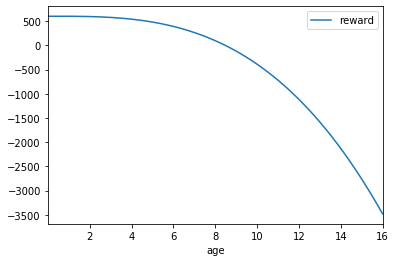

In [11]:
df.plot('age', 'reward')

In [ ]:
env.envs[0].action_space.high[2]